## 1. PREPROCESSING

In [1]:
%%capture
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LinearRegression
import pandas as pd
from matplotlib import pyplot as plt
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import os
from google.colab import drive
drive.mount('/content/drive')


### 1. Preprocessing an merging the meteo datasets (currently splitted per month)

It was decided to analyze weather data from the provinces of Piacenza and Pavia because the restaurants in question are located in the province of these cities.


In [2]:
dfs_pavia = []
dfs_piacenza = []

pavia_dir = r'/content/drive/MyDrive/Progetto/input_df/meteo/Pavia/'
piacenza_dir = r'/content/drive/MyDrive/Progetto/input_df/meteo/Piacenza/'

pavia_files = os.listdir(pavia_dir)
piacenza_files = os.listdir(piacenza_dir)

for file in pavia_files:
    df_pv = pd.read_csv(os.path.join(pavia_dir, file), sep=';')
    dfs_pavia.append(df_pv)

for file in piacenza_files:
    df_pc = pd.read_csv(os.path.join(piacenza_dir, file), sep=';')
    dfs_piacenza.append(df_pc)

m_pv = pd.concat(dfs_pavia, ignore_index=True)
m_pc = pd.concat(dfs_piacenza, ignore_index=True)


In [3]:
m_pv.head()

LOCALITA       DATA  TMEDIA °C  TMIN °C  TMAX °C  PUNTORUGIADA °C  \
0    Pavia  1/10/2018       14.0     12.0     18.0             12.0   
1    Pavia  2/10/2018       14.0      8.0     20.0              8.0   
2    Pavia  3/10/2018       15.0      8.0     21.0              9.0   
3    Pavia  4/10/2018       17.0     10.0     23.0             10.0   
4    Pavia  5/10/2018       16.0     10.0     22.0             10.0   

   UMIDITA %  VISIBILITA km  VENTOMEDIA km/h  VENTOMAX km/h  RAFFICA km/h  \
0       85.0           17.0              7.0           17.0           0.0   
1       72.0           18.0              5.0           11.0           0.0   
2       71.0           21.0              4.0            8.0           0.0   
3       68.0           19.0              5.0           11.0           0.0   
4       68.0           20.0              5.0            9.0           0.0   

   PRESSIONESLM mb  PRESSIONEMEDIA mb  PIOGGIA mm         FENOMENI  
0           1010.0                0.0         0.0         pioggia   
1           1017.0                0.0         0.0          nebbia   
2           1021.0                0.0         0.0              NaN  
3           1025.0                0.0         0.0          nebbia   
4           1023.0                0.0         0.0  pioggia nebbia

In [4]:
# Are selected columns which most readily identify the weather agents, that can be considered when choosing to go to the restaurant

sel_col = ['LOCALITA','DATA','TMEDIA °C','TMIN °C','TMAX °C','FENOMENI']
m_pv = m_pv[sel_col]
m_pc = m_pc[sel_col]

m_pv = m_pv.rename(columns={'DATA': 'data', 'LOCALITA': 'località'})
m_pc = m_pc.rename(columns={'DATA': 'data', 'LOCALITA': 'località'})

In [5]:
m_pc['FENOMENI'].unique()

array([nan, 'pioggia ', 'pioggia temporale ', 'nebbia ',
       'pioggia nebbia ', 'neve nebbia ', 'neve ', 'pioggia neve ',
       'pioggia temporale nebbia ', 'pioggia neve nebbia '], dtype=object)

In [6]:
m_pv['FENOMENI'].unique()

array(['pioggia ', 'nebbia ', nan, 'pioggia nebbia ', 'grandine nebbia ',
       'pioggia temporale ', 'neve nebbia ', 'pioggia neve nebbia ',
       'pioggia neve ', 'pioggia temporale nebbia ', 'neve '],
      dtype=object)

'FENOMENI' column is a string format description of NEGATIVE weather agents such as: rain, wind, fog... or the union of them. A new column 'atm_cond' is created that counts the number of NEGATIVE weather agents which will be a weather rating (0 to 3) that is greater when they are worse

In [7]:
def counter(stringa):
    if isinstance(stringa, str):
        return len(stringa.split())
    return 0

m_pv.loc[:,'atm_cond'] = m_pv['FENOMENI'].apply(counter)
m_pc.loc[:,'atm_cond'] = m_pc['FENOMENI'].apply(counter)

m_pc = m_pc.drop(columns=['FENOMENI'])
m_pv = m_pv.drop(columns=['FENOMENI'])


In [8]:
m_pv.head()

località       data  TMEDIA °C  TMIN °C  TMAX °C  atm_cond
0    Pavia  1/10/2018       14.0     12.0     18.0         1
1    Pavia  2/10/2018       14.0      8.0     20.0         1
2    Pavia  3/10/2018       15.0      8.0     21.0         0
3    Pavia  4/10/2018       17.0     10.0     23.0         1
4    Pavia  5/10/2018       16.0     10.0     22.0         2

In [9]:
# reading dfs of ristoranti, serie a, champions df
r_temp = pd.read_csv(r"/content/drive/MyDrive/Progetto/input_df/ristoranti.csv", sep = ';', header=0)
s_temp = pd.read_csv(r"/content/drive/MyDrive/Progetto/input_df/SerieA.csv", sep = ',', header=0)
c_temp = pd.read_csv(r"/content/drive/MyDrive/Progetto/input_df/champions.csv", sep = ',', header=0)

In [10]:
# data formatting & sorting
r_temp['data'] = pd.to_datetime(r_temp['data'], format='%Y%m%d', errors='coerce')
s_temp['data'] = pd.to_datetime(s_temp['data'], errors='coerce')
c_temp['data'] = pd.to_datetime(c_temp['data'], dayfirst=True, errors='coerce')
m_pv['data'] = pd.to_datetime(m_pv['data'], format='%d/%m/%Y')
m_pc['data'] = pd.to_datetime(m_pc['data'], format='%d/%m/%Y')


m_pv.sort_values(by='data', inplace = True)
m_pc.sort_values(by='data', inplace = True)

In [11]:
# Is choosen time interval where we have extended data for all df
# Consider that we have the following situation:
# Serie A (08/18 - 05/24), champions (02/18-05/24), restaurants (09/18-05/24)
start_date = pd.to_datetime('2018-09-01')
end_date = pd.to_datetime('2024-05-01')

rist = r_temp[(r_temp['data'] >= start_date) & (r_temp['data'] <= end_date)].reset_index(drop=True)
seriea = s_temp[(s_temp['data'] >= start_date) & (s_temp['data'] <= end_date)].reset_index(drop=True)
champ = c_temp[(c_temp['data'] >= start_date) & (c_temp['data'] <= end_date)].reset_index(drop=True)


In [12]:
# Exporting df preprocessed
rist.to_csv(r'/content/drive/MyDrive/Progetto/output_df/rist.csv', index=False)
seriea.to_csv(r'/content/drive/MyDrive/Progetto/output_df/seriea.csv', index=False)
champ.to_csv(r'/content/drive/MyDrive/Progetto/output_df/champ.csv', index=False)
m_pv.to_csv(r'/content/drive/MyDrive/Progetto/output_df/m_pv.csv', index=False)
m_pc.to_csv(r'/content/drive/MyDrive/Progetto/output_df/m_pc.csv', index=False)

Dividing the overall df in restaurant df & merging them usefull infos from other dfs

In [13]:
ristoranti = ['R001', 'R002', 'R003', 'R004', 'R005']
output_path = r'/content/drive/MyDrive/Progetto/output_df/RISTORANTI'

for i, ristorante in enumerate(ristoranti, start=1):
    rist_temp = rist[rist['ristorante'] == ristorante].reset_index(drop=True)

    # Merge meteo
    if i in [1, 2]:
        rist_temp = rist_temp.merge(m_pc, on='data', how='left')
    else:
        rist_temp = rist_temp.merge(m_pv, on='data', how='left')

    # Merge seriea
    rist_temp = rist_temp.merge(seriea, on='data', how='left')
    rist_temp['partite giornaliere'] = rist_temp['partite giornaliere'].fillna(0).astype(int)

    # Merge champions
    rist_temp['champions'] = rist_temp['data'].map(champ['data'].value_counts()).fillna(0).astype(int)

    globals()[f'rist{i}'] = rist_temp

    file_path = os.path.join(output_path, f'rist{i}.csv')
    rist_temp.to_csv(file_path, index=False)

Appling a regression to fill covid period

In [14]:
# Period to fill
start_date = '2020-03-01'
end_date = '2020-05-06'

input_folder = '/content/drive/MyDrive/Progetto/output_df/RISTORANTI'
output_folder = '/content/drive/MyDrive/Progetto/output_df/FINALI'
csv_files = [os.path.join(input_folder, f) for f in os.listdir(input_folder) if f.endswith('.csv')]

for file_path in csv_files:
  try:
        df = pd.read_csv(file_path)
  except Exception as e:
        print(f"Errore nel caricamento del file {file_path}: {e}")
        continue

  try:
        df['data'] = pd.to_datetime(df['data'])
  except Exception as e:
        print(f"Errore nella conversione della colonna 'data' nel file {file_path}: {e}")
        continue

  try:
        imputer = SimpleImputer(strategy='mean')
        df[['TMEDIA °C', 'TMIN °C', 'TMAX °C', 'atm_cond']] = imputer.fit_transform(df[['TMEDIA °C', 'TMIN °C', 'TMAX °C', 'atm_cond']])
  except Exception as e:
        print(f"Errore nell'imputazione dei valori mancanti nel file {file_path}: {e}")
        continue

  try:
        imputer_mode = SimpleImputer(strategy='most_frequent')
        df['località'] = imputer_mode.fit_transform(df[['località']]).ravel()
  except Exception as e:
        print(f"Errore nell'imputazione della colonna 'località' nel file {file_path}: {e}")
        continue

  try:
        train_data = df[(df['data'] < start_date) | (df['data'] > end_date)].copy()
        train_data['timestamp'] = train_data['data'].map(pd.Timestamp.toordinal)
  except Exception as e:
        print(f"Errore durante il filtraggio dei dati nel file {file_path}: {e}")
        continue

  try:
        X_train = train_data[['timestamp', 'TMEDIA °C', 'TMIN °C', 'TMAX °C', 'atm_cond', 'partite giornaliere', 'champions']].values
        y_train = train_data['totale'].values
  except KeyError as e:
        print(f"Errore nella selezione delle variabili indipendenti nel file {file_path}: {e}")
        continue

  try:
        model = LinearRegression()
        model.fit(X_train, y_train)
  except Exception as e:
        print(f"Errore nell'addestramento del modello nel file {file_path}: {e}")
        continue

  try:
        missing_data = df[(df['data'] >= start_date) & (df['data'] <= end_date)].copy()
        missing_data['timestamp'] = missing_data['data'].map(pd.Timestamp.toordinal)
        X_missing = missing_data[['timestamp', 'TMEDIA °C', 'TMIN °C', 'TMAX °C', 'atm_cond', 'partite giornaliere', 'champions']].values
  except KeyError as e:
        print(f"Errore nella preparazione dei dati da correggere nel file {file_path}: {e}")
        continue

  try:
        predicted_values = model.predict(X_missing)
        df.loc[(df['data'] >= start_date) & (df['data'] <= end_date), 'totale'] = predicted_values
  except Exception as e:
        print(f"Errore nella predizione dei valori mancanti nel file {file_path}: {e}")
        continue

  try:
        file_name = os.path.basename(file_path)
        new_file_name = file_name.replace('.csv', '_final.csv')
        corrected_file_path = os.path.join(output_folder, new_file_name)
        df = df[['data', 'totale', 'TMEDIA °C', 'partite giornaliere', 'champions', 'atm_cond']]
        df['data'] = pd.to_datetime(df['data'])
        df.to_csv(corrected_file_path, index=False)
  except Exception as e:
        print(f"Errore nel salvataggio del file {file_path}: {e}")


<ipython-input-14-ba0a4ef18bf5>:77: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['data'] = pd.to_datetime(df['data'])


In [15]:
df = pd.read_csv('/content/drive/MyDrive/Progetto/output_df/FINALI/rist1_final.csv')
df

data    totale  TMEDIA °C  partite giornaliere  champions  \
0     2018-09-01  37903.63       19.0                    2          0   
1     2018-09-02  32612.52       18.0                    7          0   
2     2018-09-03  18721.47       21.0                    0          0   
3     2018-09-04  18962.33       22.0                    0          0   
4     2018-09-05  17765.62       24.0                    0          0   
...          ...       ...        ...                  ...        ...   
2065  2024-04-27  36225.63       14.0                    3          0   
2066  2024-04-28  37360.53       15.0                    5          0   
2067  2024-04-29  17234.22       18.0                    1          0   
2068  2024-04-30  22008.57       20.0                    0          1   
2069  2024-05-01  35421.27       15.0                    0          1   

      atm_cond  
0          0.0  
1          1.0  
2          2.0  
3          0.0  
4          0.0  
...        ...  
2065       0.0  
2066       0.0  
2067       0.0  
2068       0.0  
2069       1.0  

[2070 rows x 6 columns]

## 2.EXPLORATION

Plotting the original Daily Invoice for each restaurant

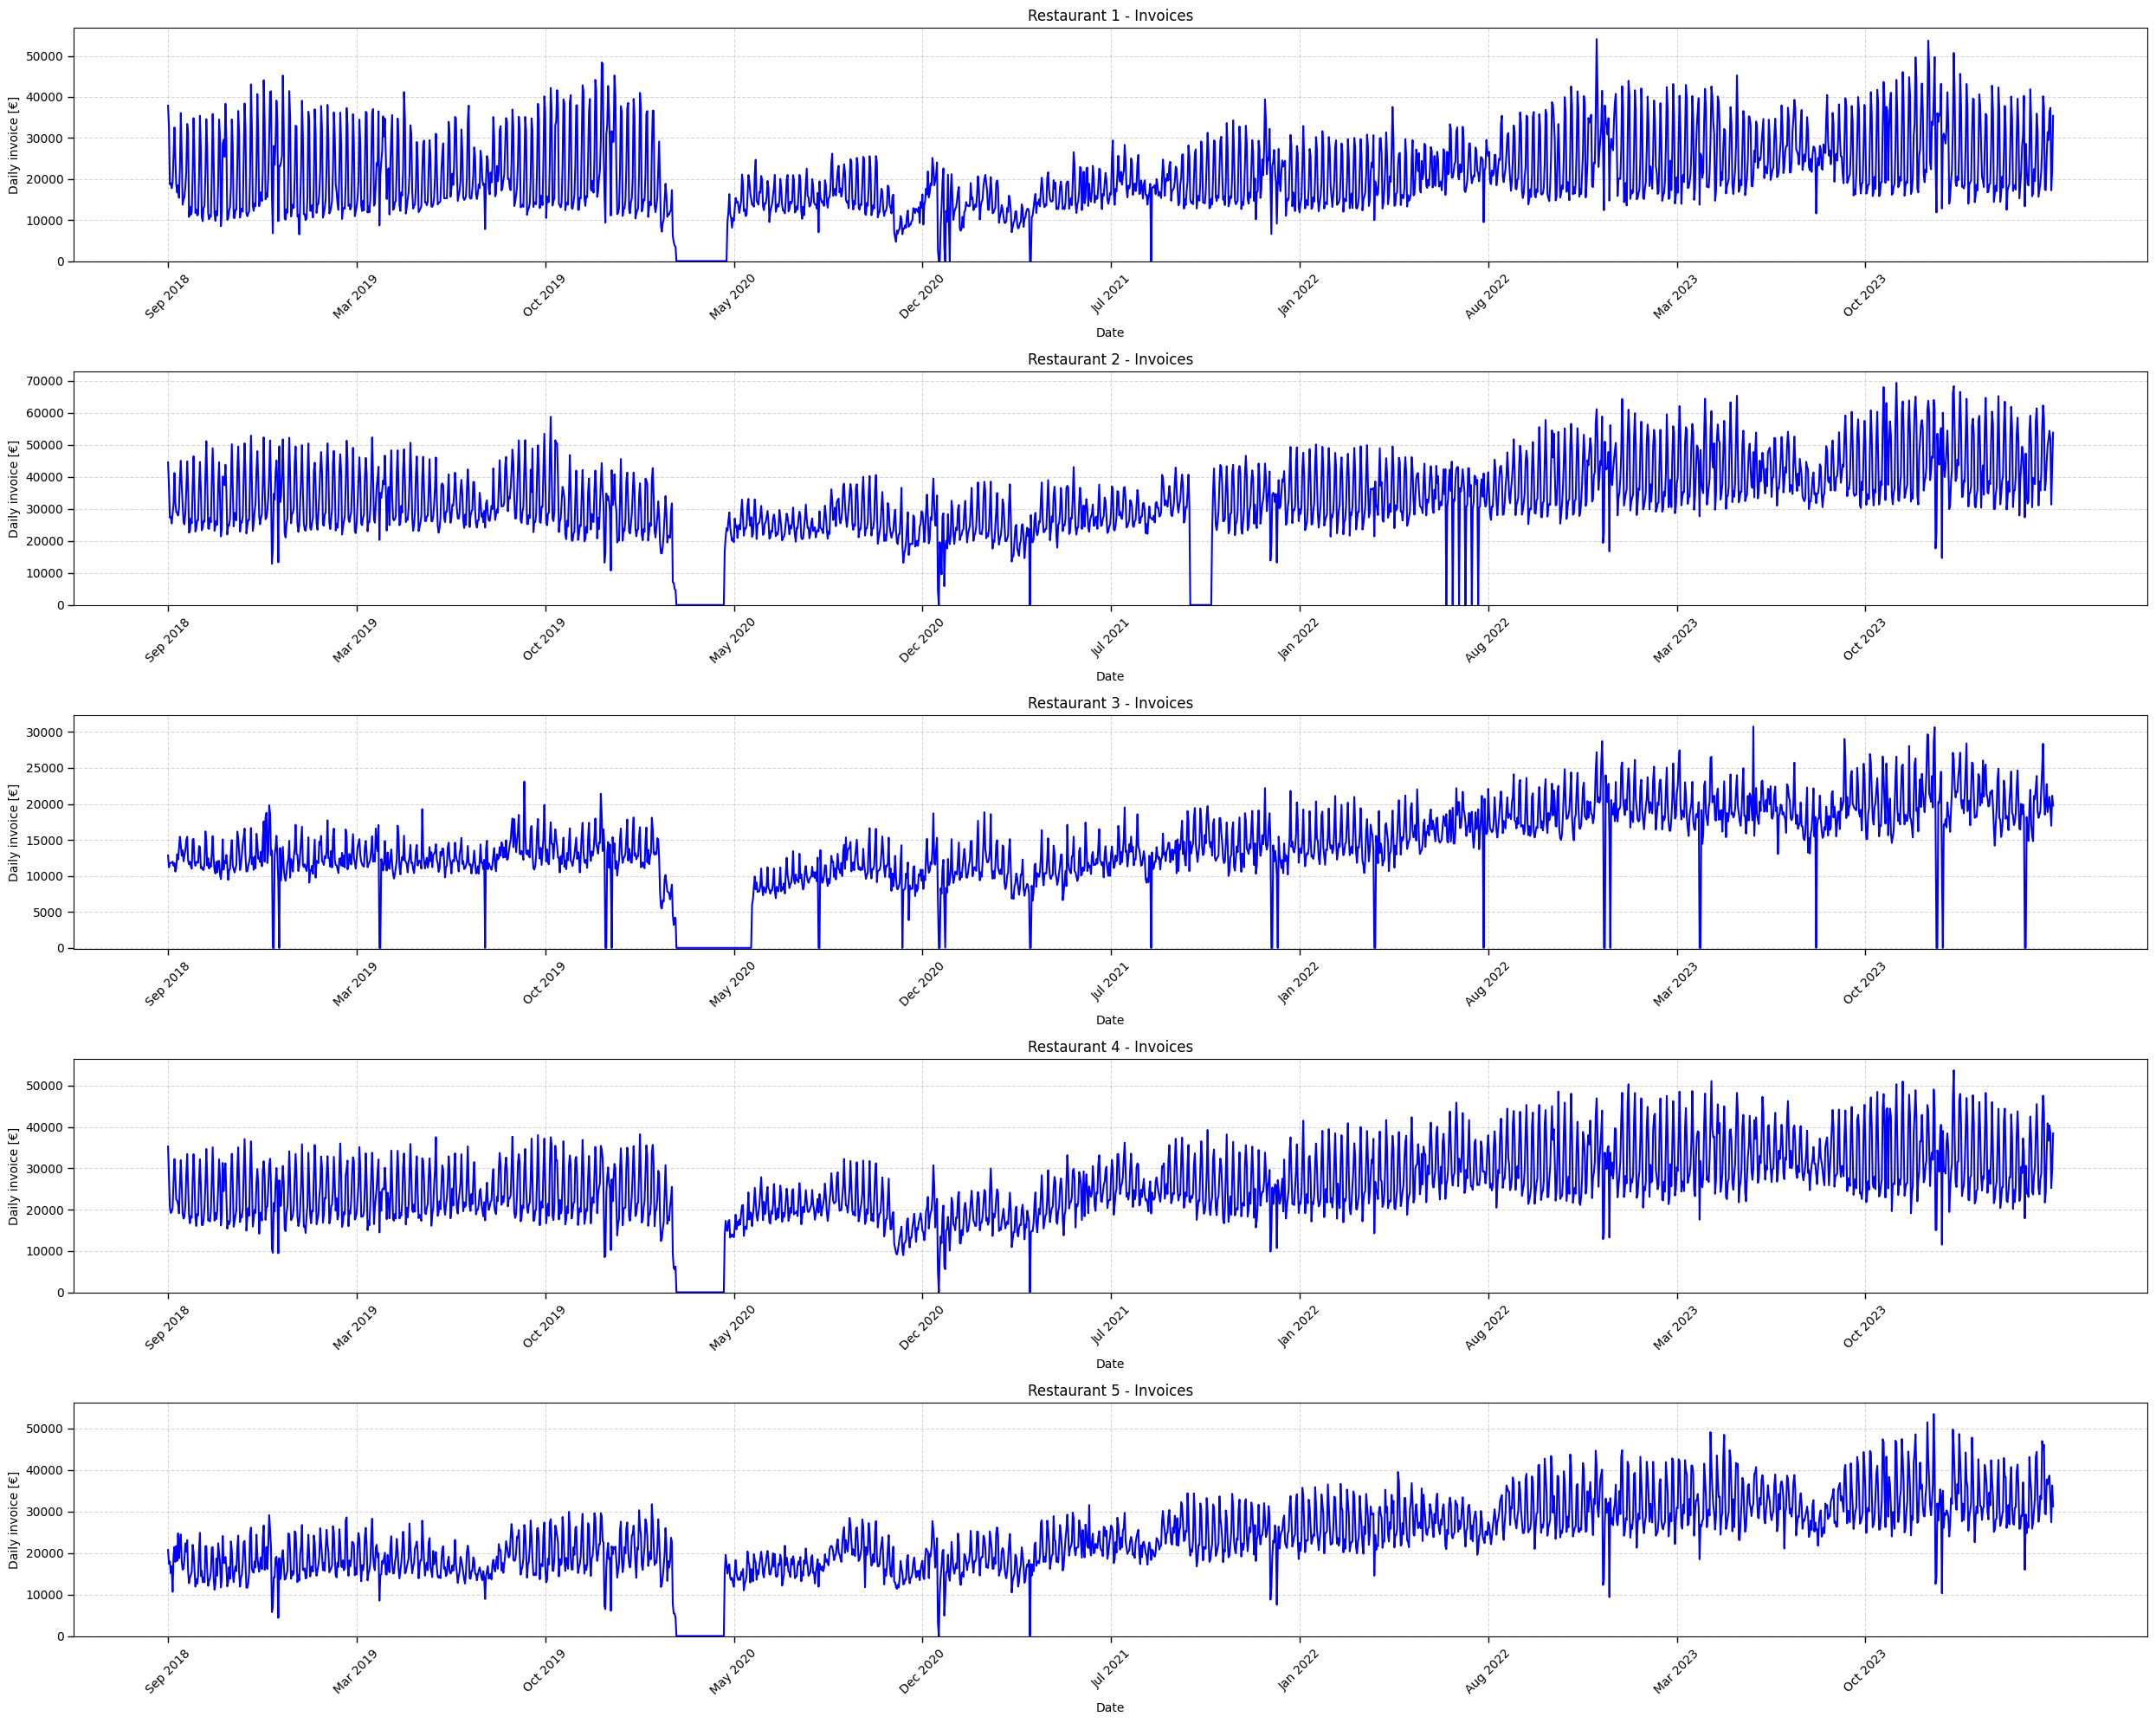

In [16]:
ristoranti = [f'rist{i}.csv' for i in range(1, 6)]
plt.figure(figsize=(25, 20))

for i, ristorante in enumerate(ristoranti, 1):
    df = pd.read_csv(f'/content/drive/MyDrive/Progetto/output_df/RISTORANTI/{ristorante}')

    df['data'] = pd.to_datetime(df['data'])

    ax = plt.subplot(5, 1, i)
    ax.plot(df['data'], df['totale'], marker='', linestyle='-', color='blue')

    ax.xaxis.set_major_locator(mdates.MonthLocator(interval=2))
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%b %Y'))
    ax.set_xticks(df['data'][::int(len(df)/10)])
    plt.xticks(rotation=45)

    ax.set_title(f"Restaurant {i} - Invoices")
    ax.set_ylim(bottom=-200)
    ax.xaxis.set_tick_params(which='both', width=1, length=5)
    ax.yaxis.set_tick_params(which='both', width=1, length=5)
    ax.set_xlabel("Date")
    ax.set_ylabel("Daily invoice [€]")
    ax.grid(True, linestyle='--', alpha=0.5)

plt.tight_layout()
plt.show()


Plotting the Daily Invoice for each filled restaurant

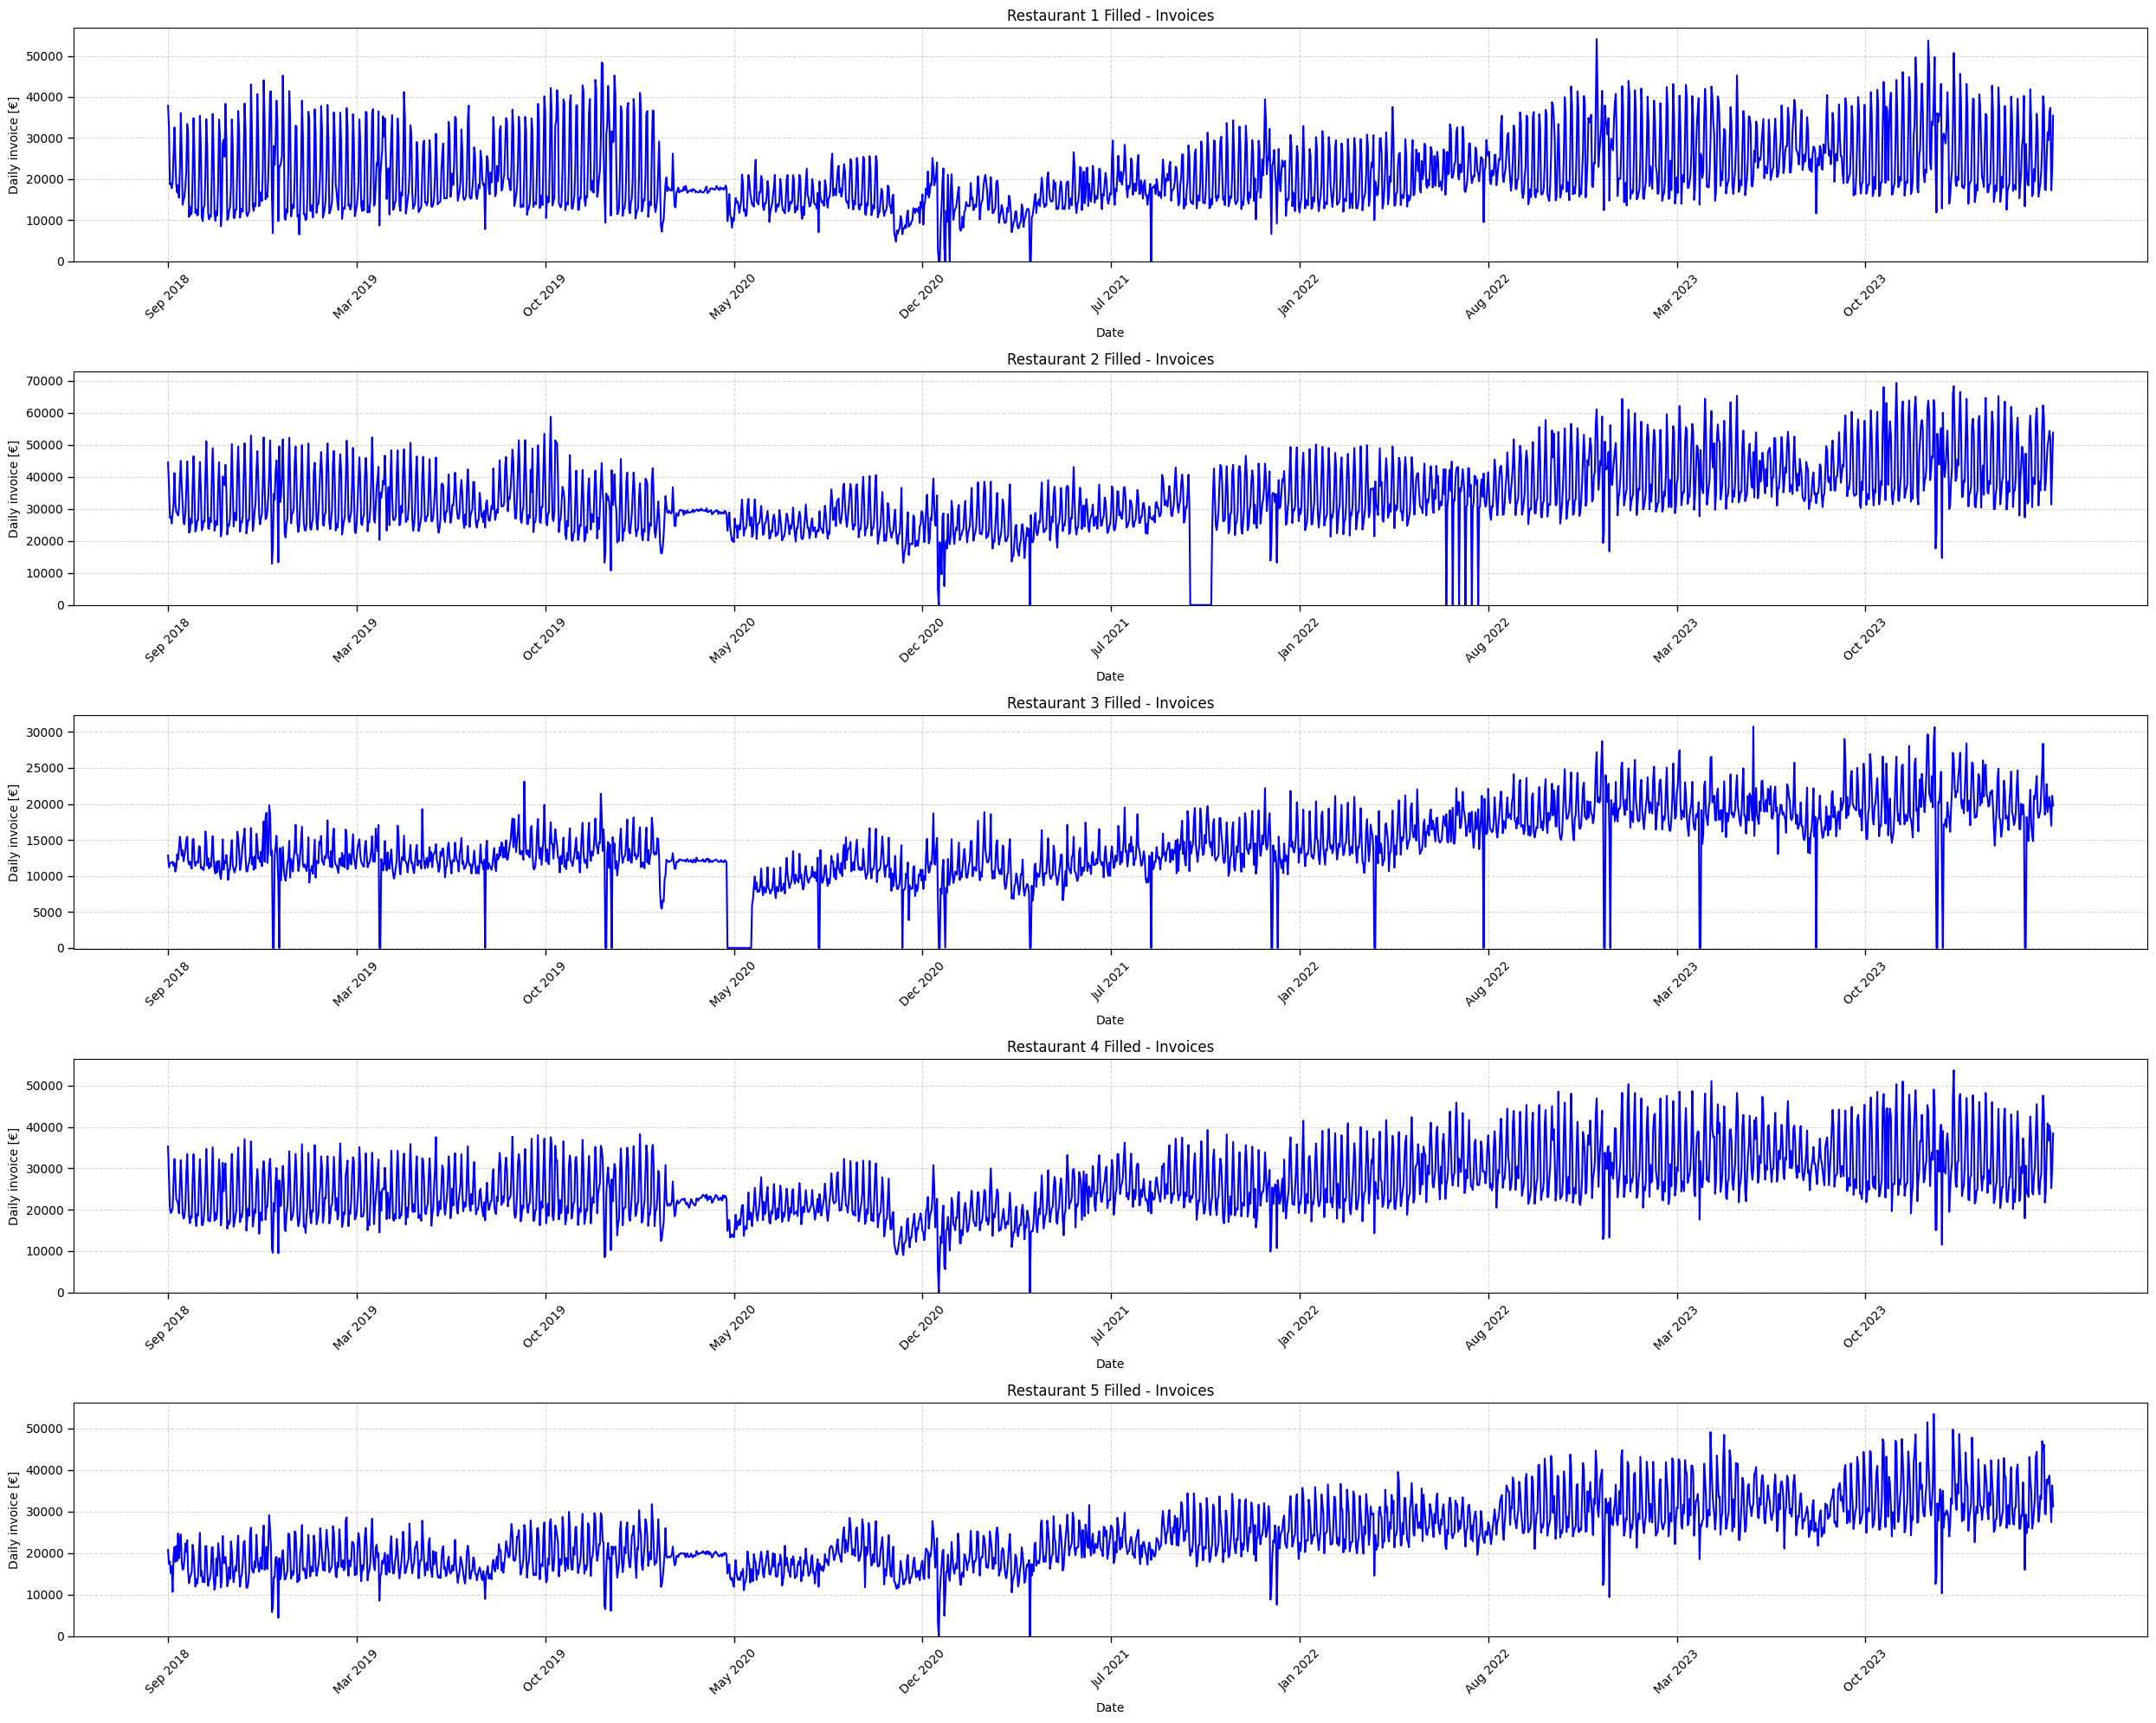

In [17]:
ristoranti_finali = [f'rist{i}_final.csv' for i in range(1, 6)]
plt.figure(figsize=(25, 20))

for i, ristorante_finale in enumerate(ristoranti_finali, 1):
    df = pd.read_csv(f'/content/drive/MyDrive/Progetto/output_df/FINALI/{ristorante_finale}')

    df['data'] = pd.to_datetime(df['data'])

    ax = plt.subplot(5, 1, i)
    ax.plot(df['data'], df['totale'], marker='', linestyle='-', color='blue')

    ax.xaxis.set_major_locator(mdates.MonthLocator(interval=2))
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%b %Y'))
    ax.set_xticks(df['data'][::int(len(df)/10)])
    plt.xticks(rotation=45)

    ax.set_title(f"Restaurant {i} Filled - Invoices")
    ax.set_ylim(bottom=-200)
    ax.xaxis.set_tick_params(which='both', width=1, length=5)
    ax.yaxis.set_tick_params(which='both', width=1, length=5)
    ax.set_xlabel("Date")
    ax.set_ylabel("Daily invoice [€]")
    ax.grid(True, linestyle='--', alpha=0.5)

plt.tight_layout()
plt.show()


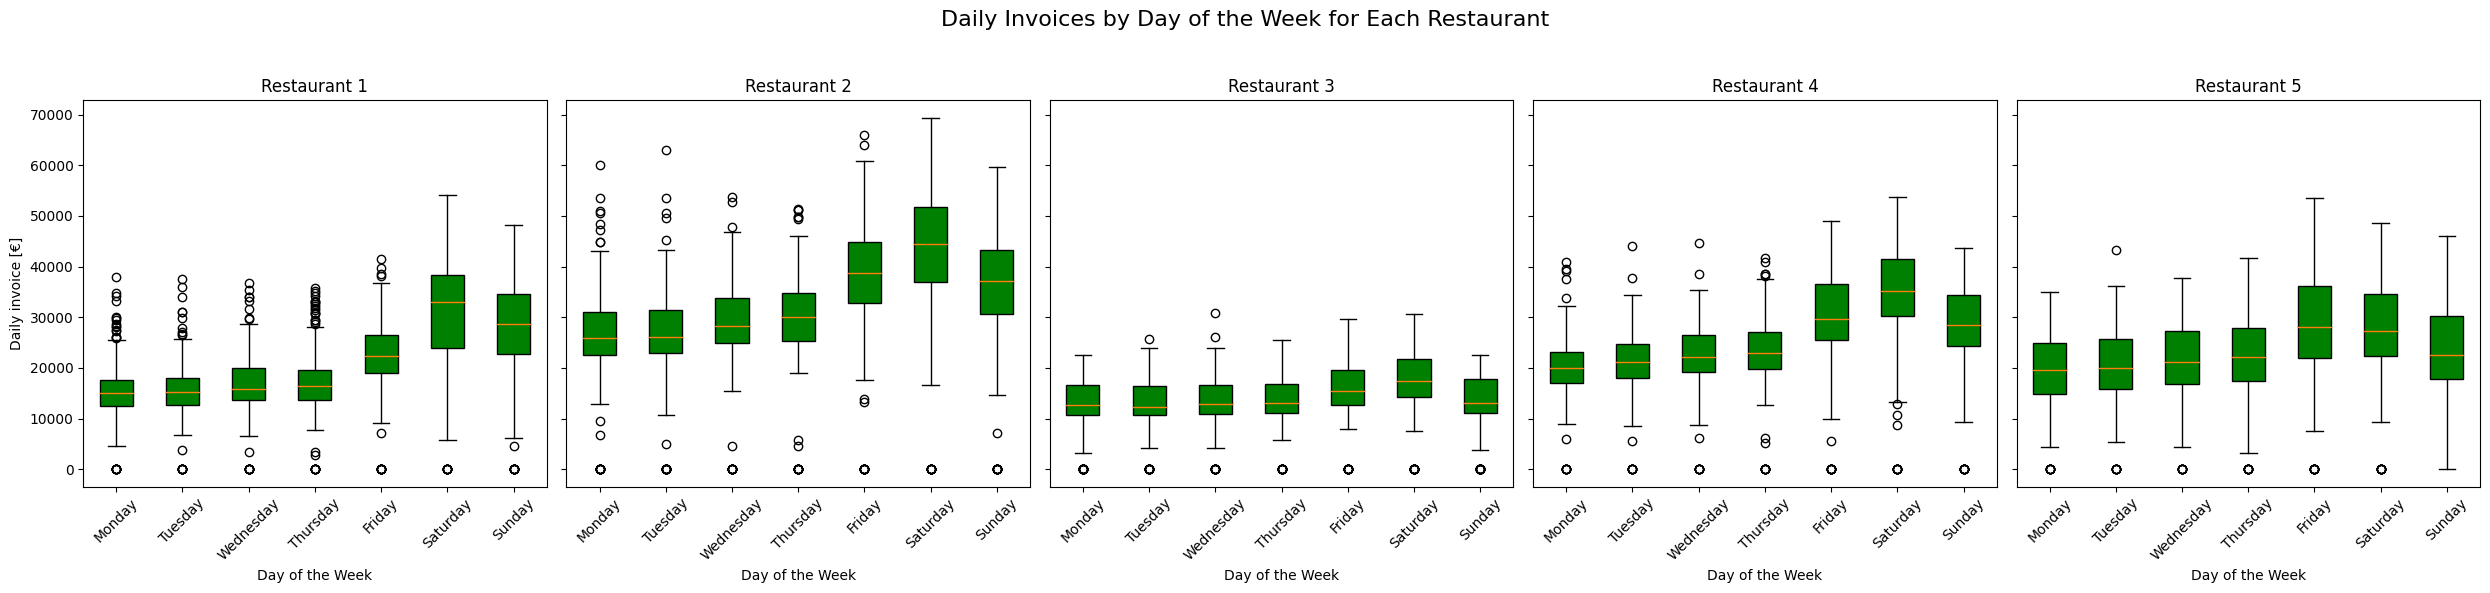

In [18]:
ristoranti = [f'rist{i}' for i in range(1, 6)]
Day_of_the_week = ["Monday", "Tuesday", "Wednesday", "Thursday", "Friday", "Saturday", "Sunday"]

fig, axes = plt.subplots(nrows=1, ncols=5, figsize=(25, 6), sharey=True)
fig.suptitle("Daily Invoices by Day of the Week for Each Restaurant", fontsize=16)

for i, ristorante in enumerate(ristoranti):
    df = pd.read_csv(f'/content/drive/MyDrive/Progetto/output_df/RISTORANTI/{ristorante}.csv')
    df['Day of the week'] = pd.to_datetime(df['data']).dt.day_name()
    df['Day of the week'] = pd.Categorical(df['Day of the week'], categories=Day_of_the_week, ordered=True)

    axes[i].boxplot(
        [df[df['Day of the week'] == day]['totale'] for day in Day_of_the_week],
        patch_artist=True,
        boxprops=dict(facecolor='green')
    )

    axes[i].set_xticks(range(1, 8))
    axes[i].set_xticklabels(Day_of_the_week, rotation=45)

    axes[i].set_title(f"Restaurant {i+1}")
    axes[i].set_xlabel("Day of the Week")

axes[0].set_ylabel("Daily invoice [€]")

plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()


Scatterplot: Seeking for a correlation between Daily matches and average Daily Invoice

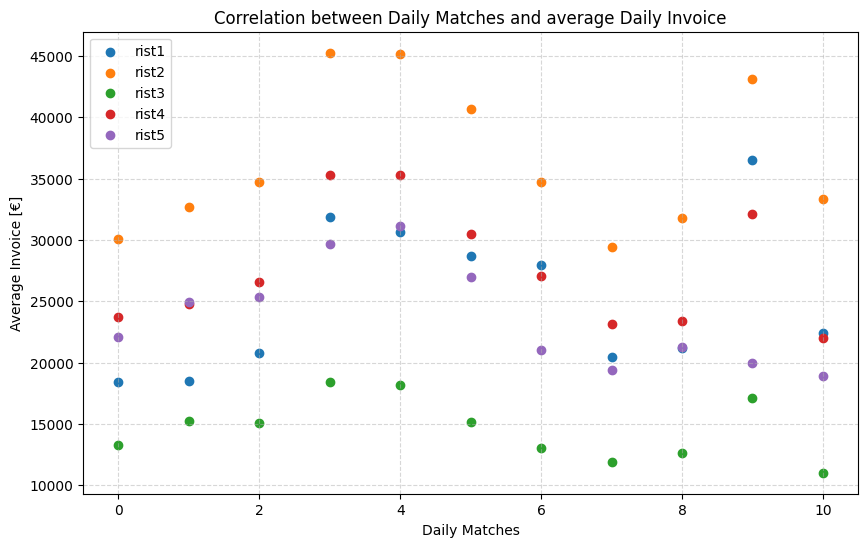

In [19]:
plt.figure(figsize=(10, 6))

for ristorante in ristoranti:
    df = pd.read_csv(f'/content/drive/MyDrive/Progetto/output_df/RISTORANTI/{ristorante}.csv')

    if 'partite giornaliere' in df.columns and 'totale' in df.columns:
        grouped_df = df.groupby('partite giornaliere')['totale'].mean().reset_index()
        plt.scatter(grouped_df['partite giornaliere'], grouped_df['totale'], label=ristorante)

plt.xlabel("Daily Matches")
plt.ylabel("Average Invoice [€]")
plt.title("Correlation between Daily Matches and average Daily Invoice")
plt.legend(loc='upper left')
plt.grid(True, linestyle='--', alpha=0.5)

plt.show()

Heatmap: Seeking for a correlation between Atmosferic condition and average Invoice. I recall that the greater is 'atm_cond' the worst are the atmosferic condition. And it is clear from the graph below that the worst atmosphericcondition low the Invoice!

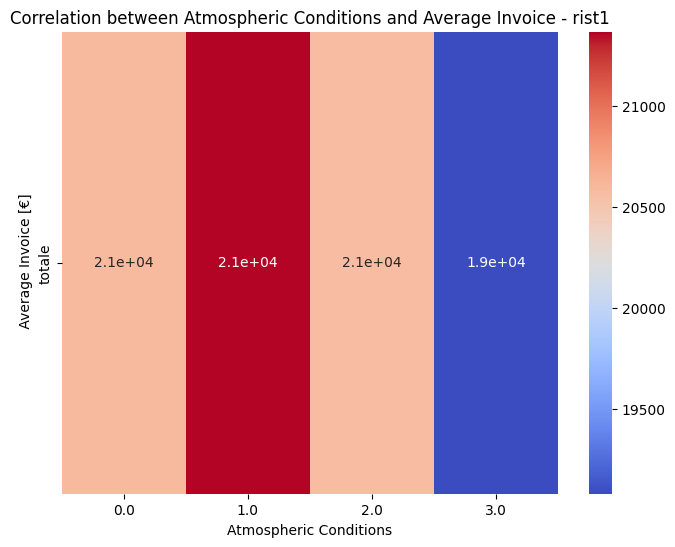

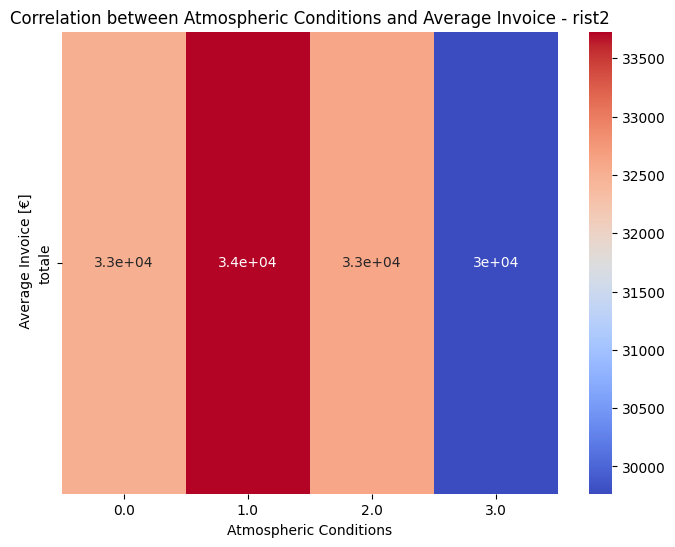

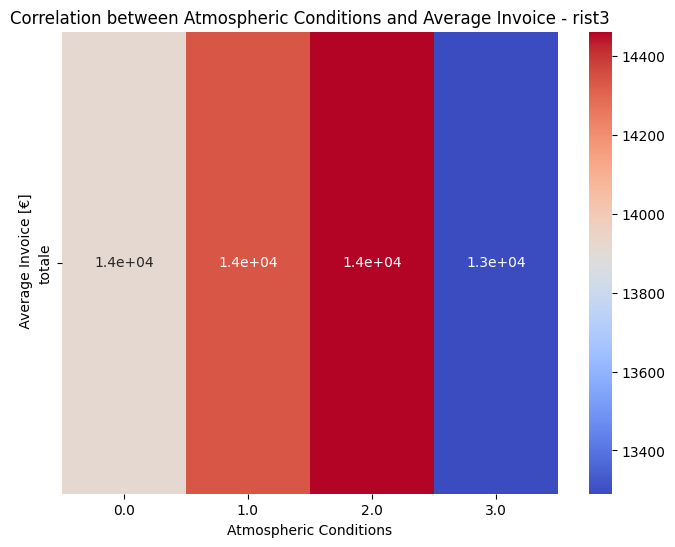

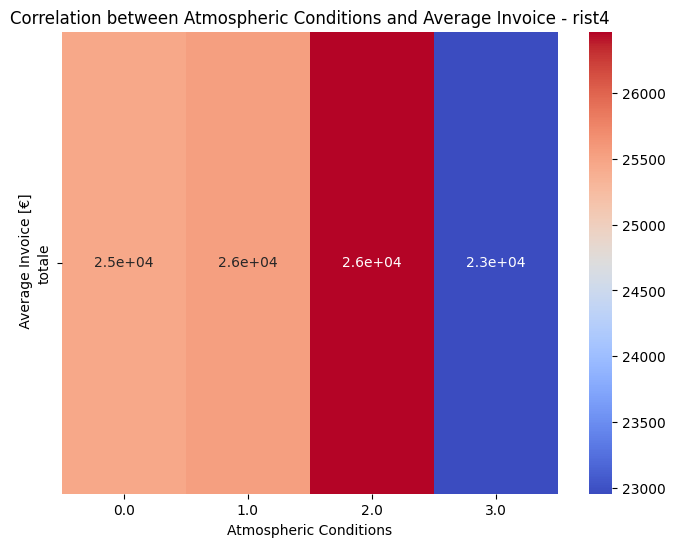

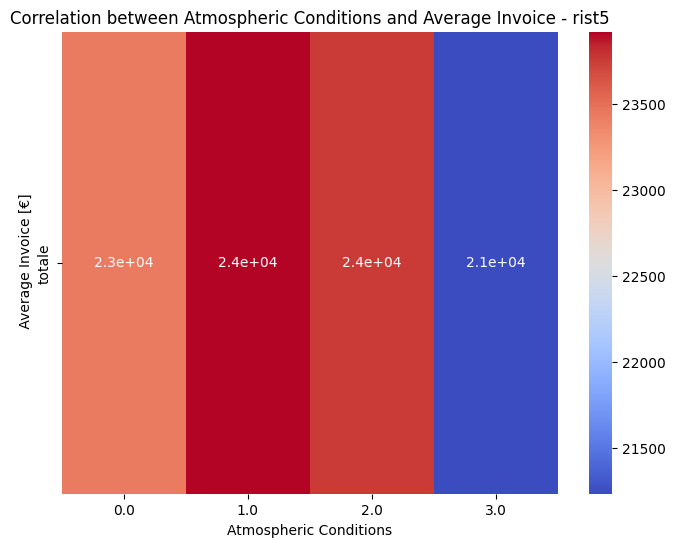

In [20]:
for ristorante in ristoranti:
    df = pd.read_csv(f'/content/drive/MyDrive/Progetto/output_df/RISTORANTI/{ristorante}.csv')

    if 'atm_cond' in df.columns and 'totale' in df.columns:
        pivot_data = df.groupby('atm_cond')['totale'].mean().reset_index()

        plt.figure(figsize=(8, 6))
        sns.heatmap(pivot_data.pivot_table(index='atm_cond', values='totale').T, cmap='coolwarm', annot=True)
        plt.title(f"Correlation between Atmospheric Conditions and Average Invoice - {ristorante}")
        plt.xlabel("Atmospheric Conditions")
        plt.ylabel(" Average Invoice [€]")
        plt.show()

## 3. MODELS

In [ ]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import os
from google.colab import drive
drive.mount('/content/drive')
import logging


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import itertools
import warnings
from datetime import datetime, timedelta

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
from pandas.plotting import lag_plot
import seaborn as sns
%matplotlib inline

from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller, kpss
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tools.sm_exceptions import ConvergenceWarning

In [ ]:
import pandas as pd

file_path = '/content/drive/MyDrive/Progetto/output_df/FINALI/rist1_final.csv'
data = pd.read_csv(file_path)

data['data'] = pd.to_datetime(data['data'])
data.set_index('data', inplace=True)

data_head = data.head()
data_tail = data.tail()

data_frequency = pd.infer_freq(data.index)

data_head, data_tail, data_frequency

(              totale  TMEDIA °C  partite giornaliere  champions  atm_cond
 data                                                                     
 2018-09-01  37903.63       19.0                    2          0       0.0
 2018-09-02  32612.52       18.0                    7          0       1.0
 2018-09-03  18721.47       21.0                    0          0       2.0
 2018-09-04  18962.33       22.0                    0          0       0.0
 2018-09-05  17765.62       24.0                    0          0       0.0,
               totale  TMEDIA °C  partite giornaliere  champions  atm_cond
 data                                                                     
 2024-04-27  36225.63       14.0                    3          0       0.0
 2024-04-28  37360.53       15.0                    5          0       0.0
 2024-04-29  17234.22       18.0                    1          0       0.0
 2024-04-30  22008.57       20.0                    0          1       0.0
 2024-05-01  35421.27   

# Dati settimanali

In [ ]:
data_cleaned = data[data.index <= '2024-04-28']

weekly_data_cleaned = data_cleaned.resample('W').agg({
    'totale': 'sum',
    'TMEDIA °C': 'mean',
    'partite giornaliere': 'sum',
    'champions': 'sum',
    'atm_cond': 'mean'
})

weekly_data_cleaned.tail()







totale  TMEDIA °C  partite giornaliere  champions  atm_cond
data                                                                      
2024-03-31  168048.41  10.714286                    5          0  0.857143
2024-04-07  189839.39  16.571429                   14          0  0.285714
2024-04-14  168350.67  18.285714                    9          4  0.285714
2024-04-21  179546.23  15.571429                   10          4  0.000000
2024-04-28  195050.04  11.428571                   11          0  0.571429

Analisi stagionalità, residui etc

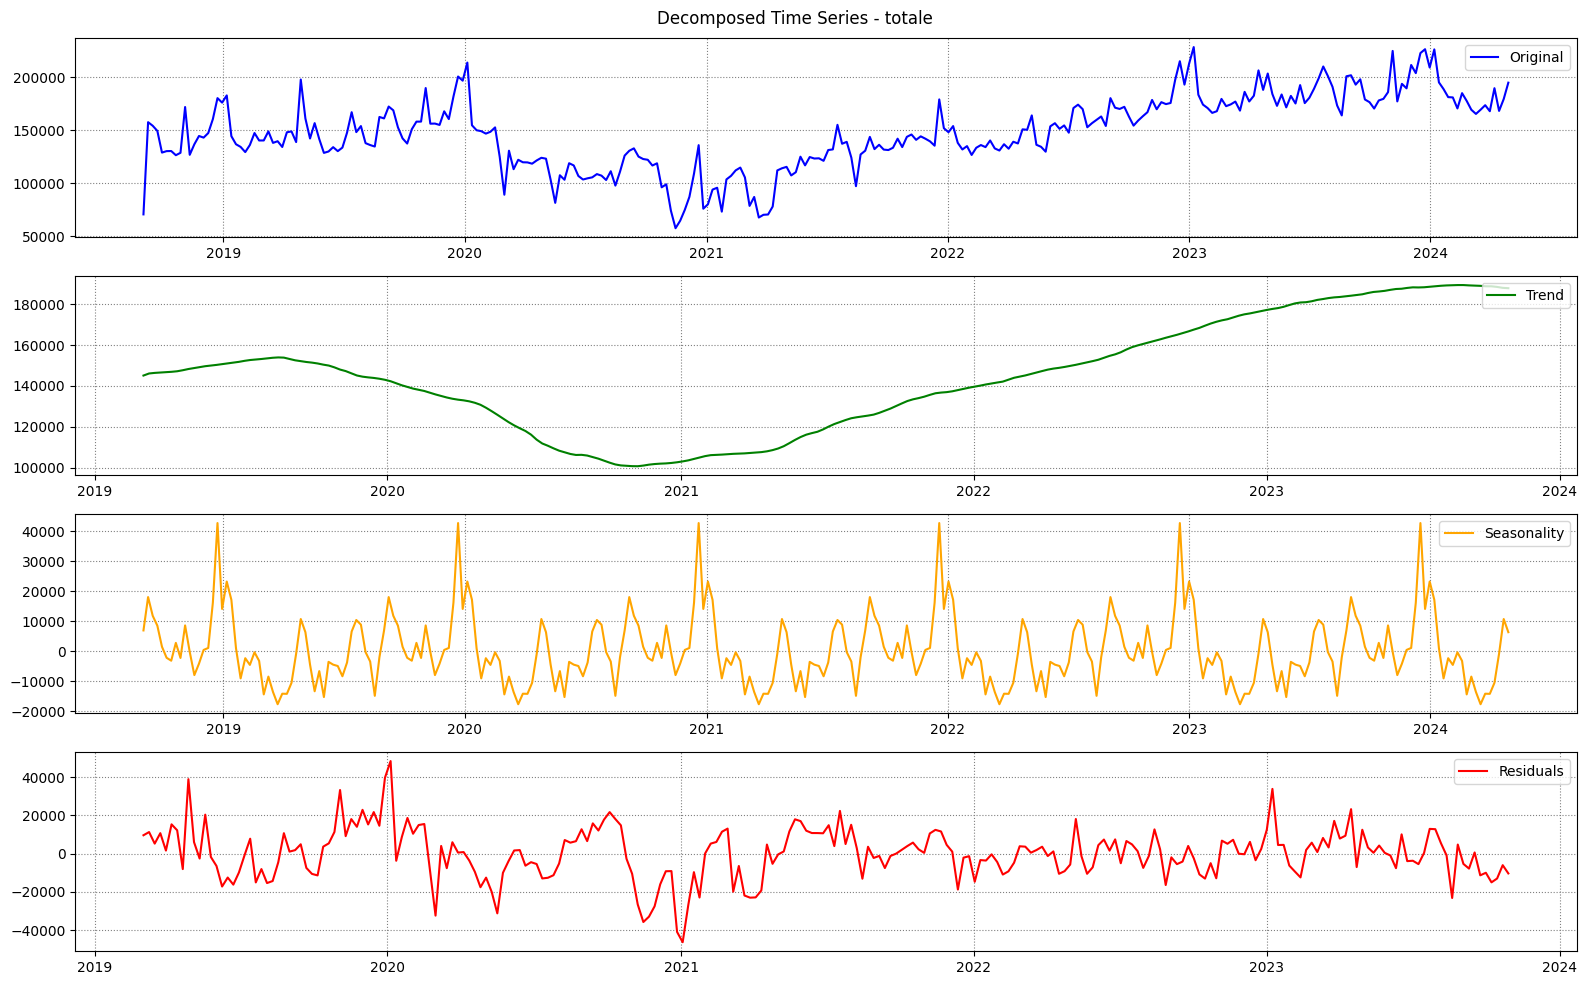

In [ ]:
from statsmodels.tsa.seasonal import seasonal_decompose
import matplotlib.pyplot as plt

def decompose_series(df: pd.DataFrame, column: str) -> None:
    """
    Questa funzione scompone una serie temporale in trend, stagionalità e residui.

    Args:
        df (pd.DataFrame): DataFrame che contiene i dati della serie temporale.
        column (str): Nome della colonna che contiene i valori della serie temporale.

    Returns:
        None
    """
    if not pd.api.types.is_datetime64_any_dtype(df.index):
        df.index = pd.to_datetime(df.index)

    decomposition = seasonal_decompose(df[column], model='additive', period=52)
    trend = decomposition.trend
    seasonal = decomposition.seasonal
    residual = decomposition.resid

    fig, (ax1, ax2, ax3, ax4) = plt.subplots(4, 1, figsize=(16, 10), facecolor='w')

    ax1.plot(df[column], label='Original', color='blue')
    ax2.plot(trend, label='Trend', color='green')
    ax3.plot(seasonal, label='Seasonality', color='orange')
    ax4.plot(residual, label='Residuals', color='red')

    ax1.legend(loc='upper right')
    ax2.legend(loc='upper right')
    ax3.legend(loc='upper right')
    ax4.legend(loc='upper right')

    ax1.grid(linestyle=":", color='grey')
    ax2.grid(linestyle=":", color='grey')
    ax3.grid(linestyle=":", color='grey')
    ax4.grid(linestyle=":", color='grey')

    plt.suptitle('Decomposed Time Series - ' + column)
    plt.tight_layout()
    plt.show()

decompose_series(weekly_data_cleaned, 'totale')


**Original Series**: The aggregated weekly time series shows significant variability, with clear peaks in 2019 and a decline in 2020. After 2021, there is a steady growth with some fluctuations in the values. This represents the overall trend of the data over time, including seasonal events and random variations.

**Trend**: The long-term trend highlights a decline between 2019 and 2021, possibly due to an external event (such as the pandemic). After this period, the trend returns to stable growth, indicating a consistent recovery up until 2024. By removing seasonality, the general tendency of the data becomes more evident.

**Seasonality**: The seasonal patterns show regular annual fluctuations, with recurring peaks that suggest cyclical behavior. These peaks could be linked to periods of high demand or specific events, such as holidays or tourist seasons. Seasonality is a recurring component that predictably influences the data.

**Residuals**: The residuals represent variations not explained by the trend and seasonality. There are significant peaks in 2019 and 2020, but overall, the residuals stabilize over time. This indicates that the decomposition model explains most of the variations, leaving only a few unpredictable anomalies.

Daily test

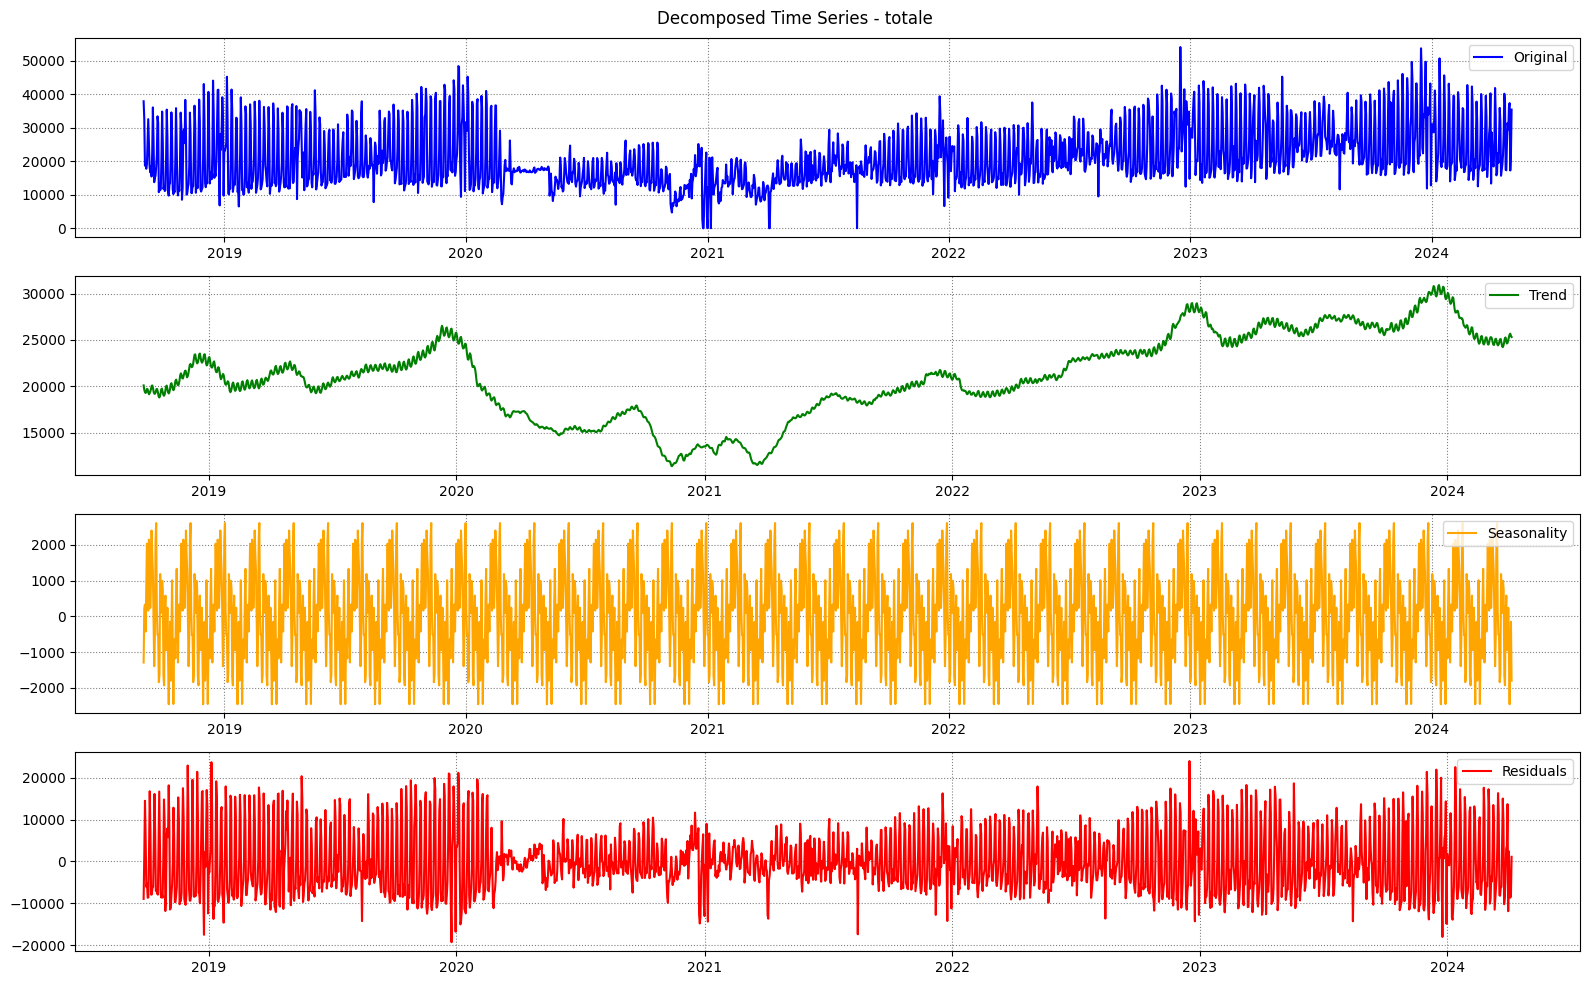

In [ ]:
decompose_series(data, 'totale')

**Original Series**: The daily series shows high variability with regular peaks and rapid fluctuations. Daily oscillations are much more noticeable compared to the weekly version. These quick movements might be due to daily influences or short-term events. Overall, there is considerable volatility in the data.

**Trend**: The long-term trend remains similar to the weekly one, with a noticeable decline between 2019 and 2021, followed by a recovery starting in 2022. However, the daily trend reveals more detailed and less linear variations. This suggests gradual changes in the phenomenon, highlighting small long-term fluctuations. The continuous growth until 2024 is evident.

**Seasonality**: The daily seasonality shows regular and more frequent patterns compared to the weekly series. Almost daily repeating cycles are observed, likely tied to weekly events or specific days. The seasonal fluctuations indicate strong short-term cyclical effects. Peaks recur regularly, showing a well-defined periodic behavior.

**Residuals**: The residuals are much more volatile in the daily data, with sudden peaks indicating anomalous events or random influences not captured by the model. This suggests the presence of unpredictable variables or daily noise. The high variability in residuals makes it difficult to explain all the fluctuations, indicating irregular events impacting the daily data.

For computational purposes, we will use the weekly data: through statistical tests, we will determine the stationarity of the time series.

In [ ]:
def perform_adf_test(df: pd.DataFrame) -> None:
    """
    Augmented Dickey Fuller Test
    - The null hypothesis for this test is that there is a unit root.
    - The alternate hypothesis is that there is no unit root in the series.
    ---
    Args:
        df (pd.DataFrame): Dataframe contains the timeseries data

    Returns: None
    """

    adf_stat, p_value, n_lags, n_observ, crit_vals, icbest = adfuller(df)

    print('\nAugmented Dickey Fuller Test')
    print('---'*15)
    print('ADF Statistic: %f' % adf_stat)
    print('p-value: %f' % p_value)
    print(f'Number of lags used: {n_lags}')
    print(f'Number of observations used: {n_observ}')
    print(f'T values corresponding to adfuller test:')
    for key, value in crit_vals.items():
        print(key, value)


def perform_kpss_test(df: pd.DataFrame) -> None:
    """
    Kwiatkowski-Phillips-Schmidt-Shin test for stationary.
    - The null hypothesis for the test is that the data is stationary.
    - The alternate hypothesis for the test is that the data is not stationary.
    ---
    Args:
        df (pd.DataFrame): Dataframe that contains the timeseries data

    Returns: None
    """

    kpss_stat, p_value, n_lags, crit_vals = kpss(df, nlags='auto', store=False)
    print('\nKwiatkowski-Phillips-Schmidt-Shin test')
    print('---'*15)
    print('KPSS Statistic: %f' % kpss_stat)
    print('p-value: %f' % p_value)
    print(f'Number of lags used: {n_lags}')
    print(f'Critical values of KPSS test:')
    for key, value in crit_vals.items():
        print(key, value)

In [ ]:
perform_adf_test(weekly_data_cleaned['totale'])
perform_kpss_test(weekly_data_cleaned['totale'])


Augmented Dickey Fuller Test
---------------------------------------------
ADF Statistic: -1.636366
p-value: 0.464160
Number of lags used: 8
Number of observations used: 287
T values corresponding to adfuller test:
1% -3.453342167806272
5% -2.871663828287282
10% -2.572164381381345

Kwiatkowski-Phillips-Schmidt-Shin test
---------------------------------------------
KPSS Statistic: 1.250766
p-value: 0.010000
Number of lags used: 10
Critical values of KPSS test:
10% 0.347
5% 0.463
2.5% 0.574
1% 0.739


<ipython-input-10-717bb18bd77b>:38: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  kpss_stat, p_value, n_lags, crit_vals = kpss(df, nlags='auto', store=False)


**Augmented Dickey-Fuller (ADF) Test:**

Since the ADF statistic is -1.636 and the p-value is 0.464, we cannot reject the null hypothesis (𝑁0), which states that a unit root exists in the time series (the series is non-stationary). The critical value at the 5% level is -2.871, and since the ADF statistic is not smaller than the critical value, this confirms that we cannot reject the null hypothesis.

Conclusion: According to the ADF test, the series is non-stationary (it has a unit root).

**Kwiatkowski-Phillips-Schmidt-Shin (KPSS) Test**: The KPSS statistic is 1.250766, which is much higher than the critical value at the 5% level of 0.463. The p-value is less than 0.01, indicating that we can reject the null hypothesis (𝑁0), which assumes that the series is stationary.

Conclusion: According to the KPSS test, the series is non-stationary. The fact that the statistic is so high suggests that the series might be non-stationary with a trend component.

Overall Conclusion:

**ADF Test**: We cannot reject the hypothesis that the series has a unit root, so the series is non-stationary.
**KPSS Test**: The KPSS test indicates that the series is non-stationary, supporting the presence of a trend.

Both tests confirm the non-stationarity of the series.

# ACF E PACF

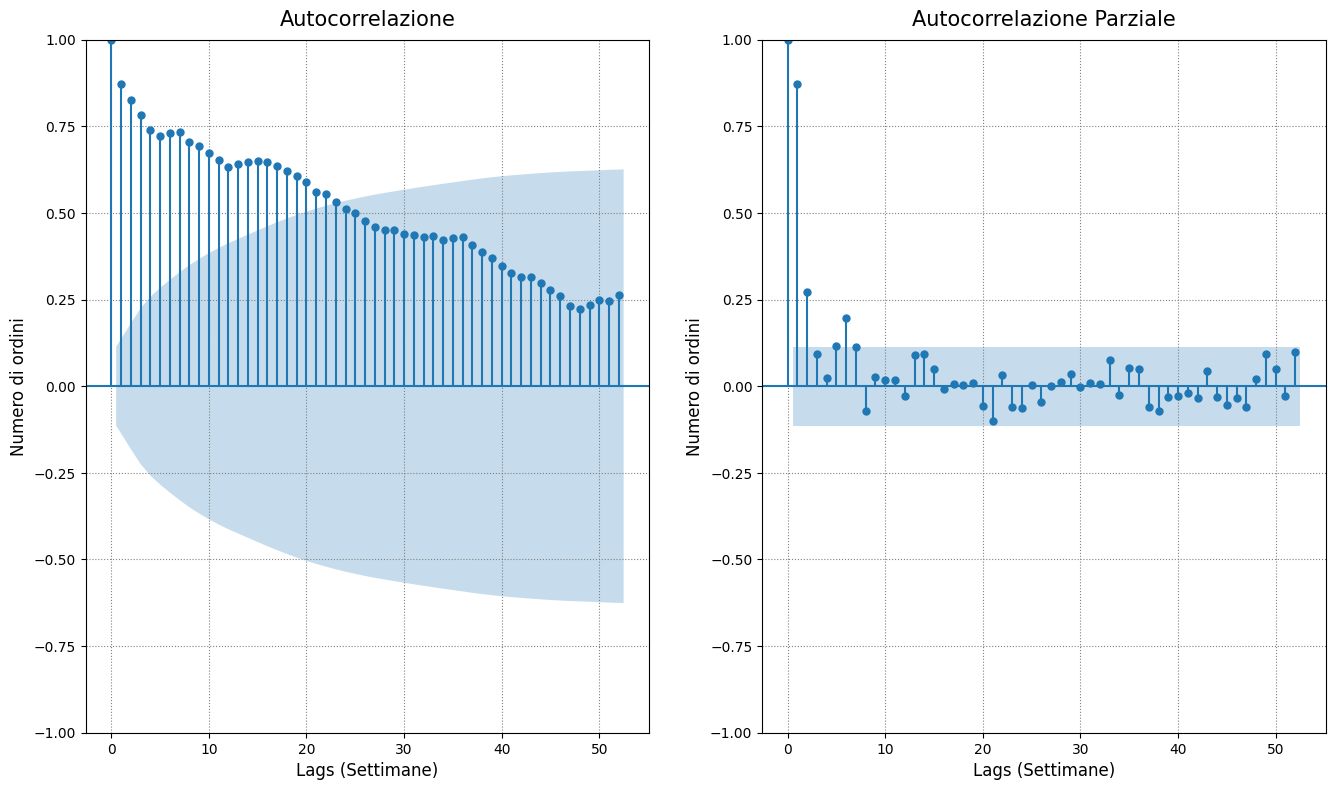

In [ ]:


def plot_acf_pacf(df: pd.DataFrame, acf_lags: int, pacf_lags: int) -> None:
    """
    Questa funzione plotta i ritardi di Autocorrelazione (ACF) e Autocorrelazione Parziale (PACF).
    ---
    Args:
        df (pd.DataFrame): Dataframe che contiene i dati di ordine e date.
        acf_lags (int): Numero di ritardi ACF
        pacf_lags (int): Numero di ritardi PACF
    Returns: None
    """

    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16,9), facecolor='w')

    plot_acf(df['totale'], ax=ax1, lags=acf_lags)
    plot_pacf(df['totale'], ax=ax2, lags=pacf_lags, method='ywm')

    ax1.set_title("Autocorrelazione", fontsize=15, pad=10)
    ax1.set_ylabel("Numero di ordini", fontsize=12)
    ax1.set_xlabel("Lags (Settimane)", fontsize=12)

    ax2.set_title("Autocorrelazione Parziale", fontsize=15, pad=10)
    ax2.set_ylabel("Numero di ordini", fontsize=12)
    ax2.set_xlabel("Lags (Settimane)", fontsize=12)

    ax1.grid(linestyle=":", color='grey')
    ax2.grid(linestyle=":", color='grey')

    plt.show()

plot_acf_pacf(weekly_data_cleaned, acf_lags=52, pacf_lags=52)


**ACF (Autocorrelation Function)**:
As we already knew, our series exhibits seasonality, and the ACF plot confirms this pattern. As we increase the lags, we observe that the significance of the lags gradually decreases, which is consistent with the presence of long-term seasonality.

The first significant lag is lag 1, which is not surprising. This indicates that the number of orders in the previous week can directly influence the orders in the current week, suggesting a strong short-term dependence.
Another significant lag is observed around lag 7 and lag 14, which could indicate a weekly pattern, as 7 represents a full week. This suggests that the orders from one week influence the orders in the following week, confirming a weekly seasonal cycle.
Overall, the ACF does not exhibit a sharp "cut-off" but decreases slowly, suggesting the presence of an autoregressive component and the need to differentiate the data to make them stationary.

**PACF (Partial Autocorrelation Function)**:
In the PACF plot, we observe that lag 1 has the most significant peak, followed by a smaller peak at lag 2. This means that the orders from the immediately preceding week have the strongest direct correlation with the current week's orders.

Lag 7 in the PACF shows another significant peak, suggesting that weekly patterns are directly correlated, supporting the idea of weekly seasonality.
The other lags do not show particularly significant peaks, indicating that autoregression is mainly important in the short term, and more distant lags do not have a significant direct impact on the series.

**Conclusions**:
The ACF plot shows clear weekly seasonality, with significant correlations at lags 1, 7, and 14, while the PACF confirms that autocorrelation is strong in the short term, with the strongest impact on the closest lags, particularly at lag 1.

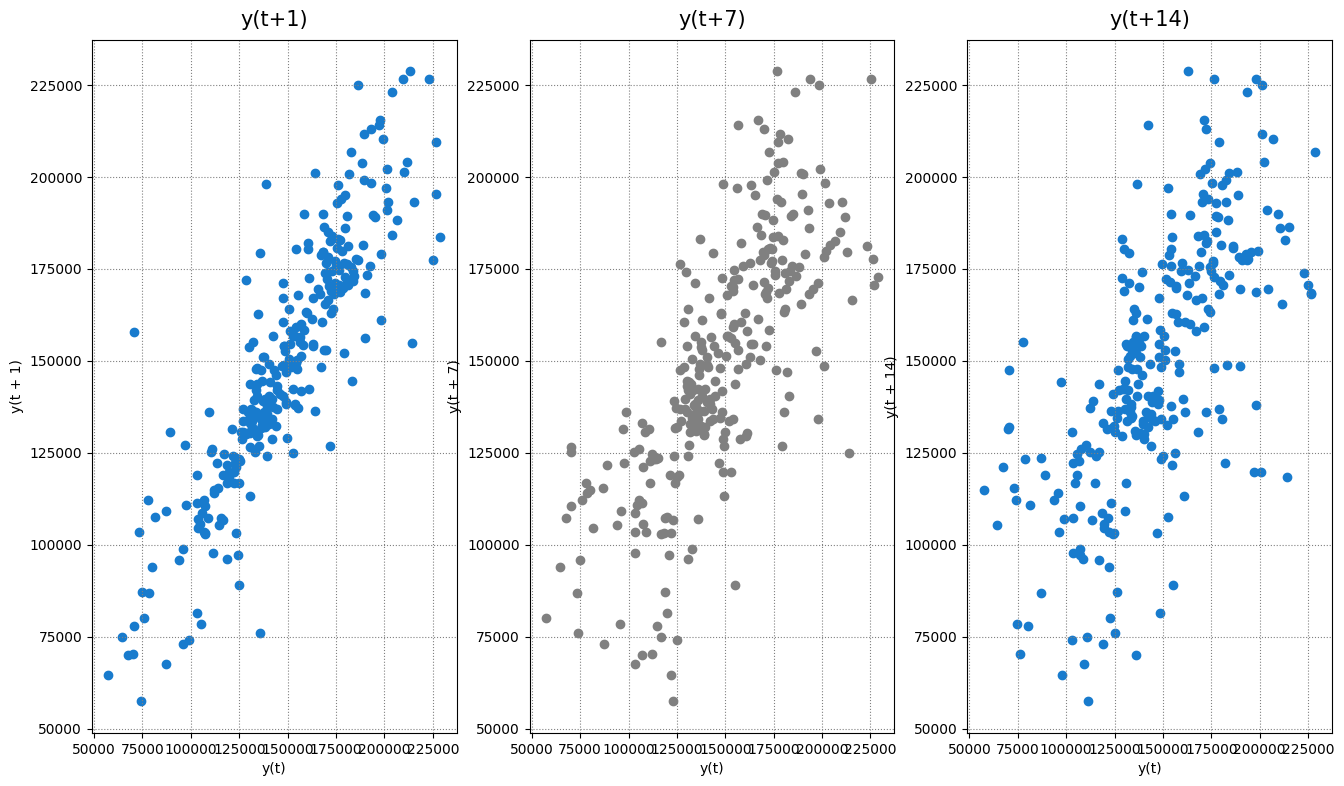

In [ ]:
def lag_plots(df: pd.DataFrame) -> None:
    """
    Questa funzione visualizza la correlazione tra
    y(t) e i ritardi y(t-1), y(t-7), e y(t-14).
    ---
    Args:
        df (pd.DataFrame): Dataframe che contiene la serie temporale

    Returns: None
    """

    fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(16,9), facecolor='w')

    lag_plot(df['totale'], lag=1, ax=ax1, c='#187bcd')
    lag_plot(df['totale'], lag=7, ax=ax2, c='grey')
    lag_plot(df['totale'], lag=14, ax=ax3, c='#187bcd')


    ax1.set_title("y(t+1)", fontsize=15, pad=10)
    ax2.set_title("y(t+7)", fontsize=15, pad=10)
    ax3.set_title("y(t+14)", fontsize=15, pad=10)

    ax1.grid(linestyle=":", color='grey')
    ax2.grid(linestyle=":", color='grey')
    ax3.grid(linestyle=":", color='grey')

    plt.show()

lag_plots(weekly_data_cleaned)


**Observations**:
Lag 1: The lag 1 plot shows a clear positive linear correlation between
𝑦
(
𝑡
)
y(t) e
𝑦
(
𝑡
+
1
)
y(t+1).

This confirms that the values of the previous week have a strong impact on the current week's values, as observed in the ACF plot. The linear relationship indicates a strong short-term dependence between consecutive values in the time series.

Lag 7: The lag 7 plot shows a more dispersed, yet still positive, correlation. This is consistent with the idea of weekly seasonality: the values from the same week of the previous cycle (7 weeks before) influence the current values, but with a less strict correlation compared to lag 1. The spread of points suggests that other variables or noise might be influencing this relationship.

Lag 14: Similarly, the lag 14 plot shows a positive correlation, similar to lag 7, but with slightly more dispersion. This confirms that a bi-weekly correlation exists, though weaker than that of lag 1. The greater dispersion compared to lag 1 suggests that the effect of the bi-weekly cycle is present but weaker and less predictable.

**Conclusion**:
These plots confirm the patterns observed in the ACF, with a strong short-term linear correlation at lag 1 and evident weekly seasonality at lag 7, along with a weaker but still present correlation over a two-week cycle (lag 14). These results provide useful insights for including autoregressive (AR) components in future models, especially for lag 1 and weekly seasonality.

# AIC

**AIC** (Akaike Information Criterion) is a metric used to compare statistical models, such as SARIMAX models, and evaluate which one best fits the data. The AIC balances the quality of a model’s fit to the data with its complexity.

AIC Formula:

- **AIC = 2k − 2ln(L)**
- k: The number of parameters in the model (more parameters mean greater complexity).
- L: The maximum likelihood (log-likelihood) of the model on the data (how well the model fits the data).


Interpretation:
Models with a lower AIC are preferred. A low AIC means that the model fits the data well while maintaining minimal complexity.
AIC balances the trade-off between overfitting (a model that is too complex) and underfitting (a model that is too simple). A model with many parameters might fit the data better but risks losing generalization.

Why Choose Parameters That Lower the AIC:
A lower AIC indicates that the model captures the patterns in the data better without becoming excessively complex.
Choosing parameters that minimize the AIC helps you build a model that is both accurate and general, reducing the chance of overfitting on the training data and maintaining a good level of accuracy on future predictions.

In summary, reducing the AIC helps you choose a model that is overall better at balancing accuracy and complexity.

SARIMAX MODEL WITH PARAMETER OPTIMIZATION
---



SARIMAX pipeline with AIC minimization function, applied only to the first restaurant.

RMSE: 14442.96
MAPE: 7.92%
Previsione per la settimana 2024-05-05 - 2024-05-05: 184172.64954056693


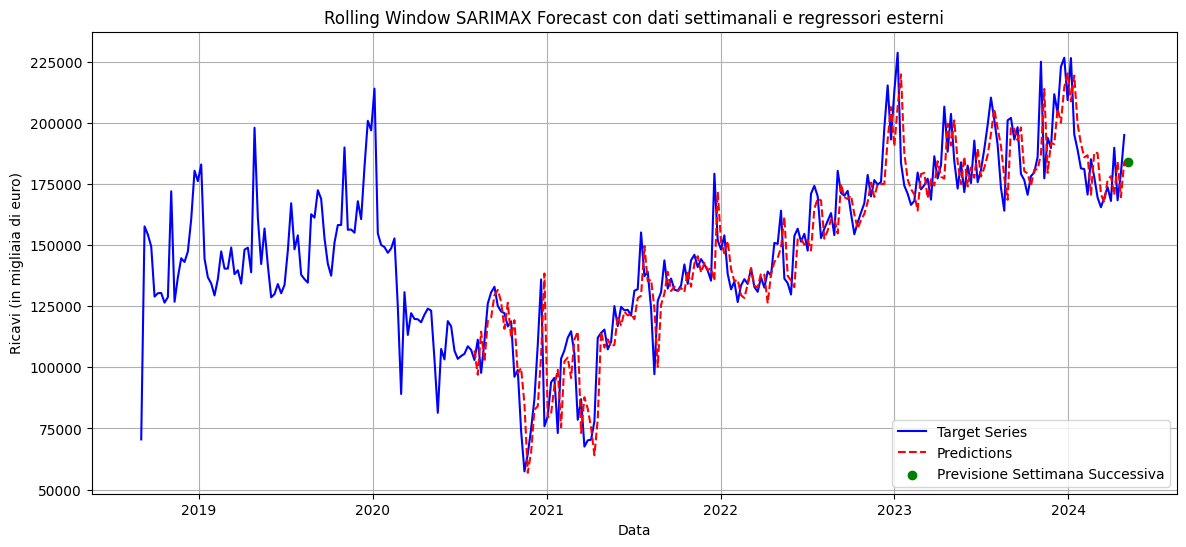

In [ ]:
import numpy as np
import pandas as pd
import itertools
from statsmodels.tsa.statespace.sarimax import SARIMAX
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error
import warnings
warnings.filterwarnings("ignore")

# Funzione per calcolare RMSE e MAPE con arrotondamento a due cifre decimali
def calculate_rmse_mape(true_values, predictions):
    rmse = np.sqrt(mean_squared_error(true_values, predictions))
    mape = np.mean(np.abs((true_values - predictions) / true_values)) * 100
    return round(rmse, 2), round(mape, 2)

# Aggiungiamo la frequenza settimanale ai dati
weekly_data_cleaned.index = pd.to_datetime(weekly_data_cleaned.index)
weekly_data_cleaned = weekly_data_cleaned.asfreq('W-SUN')

# Selezioniamo le variabili target ed esogene
target_column = 'totale'
exog_columns = ['TMEDIA °C', 'partite giornaliere', 'champions', 'atm_cond']

# Definiamo la finestra di rolling window e i parametri del modello SARIMAX
rolling_window_size = 100

p_range = range(0, 2)
d_range = range(0, 2)
q_range = range(0, 2)
P_range = range(0, 1)
D_range = range(0, 1)
Q_range = range(0, 1)
s = 52

def find_best_sarimax_params(train_data, exog_train, p_range, d_range, q_range, P_range, D_range, Q_range, s):
    best_aic = np.inf
    best_params = None
    best_seasonal_params = None

    for p, d, q in itertools.product(p_range, d_range, q_range):
        for P, D, Q in itertools.product(P_range, D_range, Q_range):
            try:
                model = SARIMAX(train_data[target_column],
                                exog=exog_train,
                                order=(p, d, q),
                                seasonal_order=(P, D, Q, s))
                model_fit = model.fit(disp=False, maxiter=20)
                aic = model_fit.aic
                if aic < best_aic:
                    best_aic = aic
                    best_params = (p, d, q)
                    best_seasonal_params = (P, D, Q, s)
            except (ValueError, np.linalg.LinAlgError):
                continue

    return best_params, best_seasonal_params, best_aic

train_data_initial = weekly_data_cleaned[:rolling_window_size]
exog_train_initial = train_data_initial[exog_columns]

best_params, best_seasonal_params, best_aic = find_best_sarimax_params(
    train_data_initial, exog_train_initial, p_range, d_range, q_range, P_range, D_range, Q_range, s
)

predictions = []
true_values = []

for i in range(rolling_window_size, len(weekly_data_cleaned)):
    train_data = weekly_data_cleaned[:i]
    exog_train = train_data[exog_columns]

    model = SARIMAX(train_data[target_column],
                    exog=exog_train,
                    order=best_params,
                    seasonal_order=best_seasonal_params)

    try:
        model_fit = model.fit(disp=False, maxiter=20)
        exog_test = weekly_data_cleaned[exog_columns].iloc[i:i+1]
        pred = model_fit.forecast(steps=1, exog=exog_test)
        predictions.append(pred.iloc[0])
        true_values.append(weekly_data_cleaned[target_column].iloc[i])
    except (ValueError, np.linalg.LinAlgError):
        predictions.append(np.nan)
        true_values.append(weekly_data_cleaned[target_column].iloc[i])

predictions_series = pd.Series(predictions, index=weekly_data_cleaned.index[rolling_window_size:])
true_values_series = pd.Series(true_values, index=weekly_data_cleaned.index[rolling_window_size:])

rmse, mape = calculate_rmse_mape(true_values_series, predictions_series)

print(f"RMSE: {rmse}")
print(f"MAPE: {mape}%")

# Previsione per la settimana successiva
next_week_index = pd.date_range(start='2024-04-29', end='2024-05-05', freq='W-SUN')
exog_next_week = weekly_data_cleaned[exog_columns].iloc[-1:]
next_week_prediction = model_fit.forecast(steps=1, exog=exog_next_week)

print(f"Previsione per la settimana {next_week_index[0].strftime('%Y-%m-%d')} - {next_week_index[-1].strftime('%Y-%m-%d')}: {next_week_prediction.iloc[0]}")

# Aggiustiamo plt.scatter per usare solo il primo elemento di next_week_index
plt.figure(figsize=(14, 6))

plt.plot(weekly_data_cleaned.index, weekly_data_cleaned[target_column], label='Target Series', color='blue', linestyle='-', linewidth=1.5)
plt.plot(predictions_series.index, predictions_series, label='Predictions', linestyle='--', color='red', linewidth=1.5)

# Usare il primo valore di next_week_index per plt.scatter
plt.scatter(next_week_index[0], next_week_prediction.iloc[0], color='green', label='Previsione Settimana Successiva')

plt.title("Rolling Window SARIMAX Forecast con dati settimanali e regressori esterni")
plt.xlabel('Data')
plt.ylabel('Ricavi (in migliaia di euro)')

plt.grid(True)
plt.legend()
plt.show()



Transformation of all restaurant files into weekly data

In [ ]:
input_directory = '/content/drive/MyDrive/Progetto/output_df/FINALI'
output_directory = '/content/drive/MyDrive/Progetto/output_df/FINALI SETTIMANALI'

if not os.path.exists(output_directory):
    os.makedirs(output_directory)

for filename in os.listdir(input_directory):
    if filename.endswith(".csv"):
        file_path = os.path.join(input_directory, filename)

        data = pd.read_csv(file_path, index_col='data', parse_dates=True)

        data_cleaned = data[data.index <= '2024-04-28']

        weekly_data_cleaned = data_cleaned.resample('W').agg({
            'totale': 'sum',
            'TMEDIA °C': 'mean',
            'partite giornaliere': 'sum',
            'champions': 'sum',
            'atm_cond': 'mean'
        })

        output_file_path = os.path.join(output_directory, filename)
        weekly_data_cleaned.to_csv(output_file_path)

        print(f"File '{filename}' processato e salvato nella cartella 'FINALI SETTIMANALI'")

File 'rist3_final.csv' processato e salvato nella cartella 'FINALI SETTIMANALI'
File 'rist1_final.csv' processato e salvato nella cartella 'FINALI SETTIMANALI'
File 'rist5_final.csv' processato e salvato nella cartella 'FINALI SETTIMANALI'
File 'rist4_final.csv' processato e salvato nella cartella 'FINALI SETTIMANALI'
File 'rist2_final.csv' processato e salvato nella cartella 'FINALI SETTIMANALI'


Application of sarimax pipeline on all resturants

In [ ]:


warnings.filterwarnings("ignore")


def calculate_rmse_mape(true_values, predictions):
    rmse = np.sqrt(mean_squared_error(true_values, predictions))

    mask = true_values != 0
    true_values_filtered = true_values[mask]
    predictions_filtered = predictions[mask]

    if len(true_values_filtered) == 0:
        mape = None
    else:
        mape = np.mean(np.abs((true_values_filtered - predictions_filtered) / true_values_filtered)) * 100

    return round(rmse, 2), round(mape, 2) if mape is not None else None

directory = '/content/drive/MyDrive/Progetto/output_df/FINALI SETTIMANALI'

rmse_list = []
mape_list = []

for filename in os.listdir(directory):
    if filename.endswith(".csv"):
        file_path = os.path.join(directory, filename)

        weekly_data_cleaned = pd.read_csv(file_path, index_col='data', parse_dates=True)

        weekly_data_cleaned = weekly_data_cleaned.asfreq('W-SUN')

        target_column = 'totale'
        exog_columns = ['TMEDIA °C', 'partite giornaliere', 'champions', 'atm_cond']

        rolling_window_size = 100
        p_range = range(0, 2)
        d_range = range(0, 2)
        q_range = range(0, 2)
        P_range = range(0, 1)
        D_range = range(0, 1)
        Q_range = range(0, 1)
        s = 52


        def find_best_sarimax_params(train_data, exog_train, p_range, d_range, q_range, P_range, D_range, Q_range, s):
            best_aic = np.inf
            best_params = None
            best_seasonal_params = None

            for p, d, q in itertools.product(p_range, d_range, q_range):
                for P, D, Q in itertools.product(P_range, D_range, Q_range):
                    try:
                        model = SARIMAX(train_data[target_column],
                                        exog=exog_train,
                                        order=(p, d, q),
                                        seasonal_order=(P, D, Q, s))
                        model_fit = model.fit(disp=False, maxiter=20)
                        aic = model_fit.aic
                        if aic < best_aic:
                            best_aic = aic
                            best_params = (p, d, q)
                            best_seasonal_params = (P, D, Q, s)
                    except (ValueError, np.linalg.LinAlgError):
                        continue

            return best_params, best_seasonal_params, best_aic

        train_data_initial = weekly_data_cleaned[:rolling_window_size]
        exog_train_initial = train_data_initial[exog_columns]

        best_params, best_seasonal_params, best_aic = find_best_sarimax_params(
            train_data_initial, exog_train_initial, p_range, d_range, q_range, P_range, D_range, Q_range, s
        )

        predictions = []
        true_values = []

        for i in range(rolling_window_size, len(weekly_data_cleaned)):
            train_data = weekly_data_cleaned[:i]
            exog_train = train_data[exog_columns]

            model = SARIMAX(train_data[target_column],
                            exog=exog_train,
                            order=best_params,
                            seasonal_order=best_seasonal_params)

            try:
                model_fit = model.fit(disp=False, maxiter=20)
                exog_test = weekly_data_cleaned[exog_columns].iloc[i:i+1]
                pred = model_fit.forecast(steps=1, exog=exog_test)
                predictions.append(pred.iloc[0])
                true_values.append(weekly_data_cleaned[target_column].iloc[i])
            except (ValueError, np.linalg.LinAlgError):
                predictions.append(np.nan)
                true_values.append(weekly_data_cleaned[target_column].iloc[i])

        predictions_series = pd.Series(predictions, index=weekly_data_cleaned.index[rolling_window_size:])
        true_values_series = pd.Series(true_values, index=weekly_data_cleaned.index[rolling_window_size:])

        rmse, mape = calculate_rmse_mape(true_values_series, predictions_series)

        if rmse is not None and mape is not None:
            rmse_list.append(rmse)
            mape_list.append(mape)

        print(f"File: {filename} - RMSE: {rmse}, MAPE: {mape}%")

if len(rmse_list) > 0 and len(mape_list) > 0:
    mean_rmse = np.mean(rmse_list)
    mean_mape = np.mean(mape_list)

    print(f"Media RMSE: {mean_rmse}")
    print(f"Media MAPE: {mean_mape}%")
else:
    print("Nessun dato valido per il calcolo di RMSE e MAPE.")


File: rist3_final.csv - RMSE: 11509.51, MAPE: 7.98%
File: rist1_final.csv - RMSE: 14443.09, MAPE: 7.92%
File: rist4_final.csv - RMSE: 14197.53, MAPE: 6.18%
File: rist5_final.csv - RMSE: 15095.26, MAPE: 6.45%
File: rist2_final.csv - RMSE: 26786.89, MAPE: 6.62%
Media RMSE: 16406.456
Media MAPE: 7.029999999999999%


# TBATS

apply the TBATS pipeline to the first restaurant (note: there are no external regressors in TBATS).





In [ ]:
!pip install tbats

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.0/44.0 kB 785.0 kB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 11.3 MB/s eta 0:00:00


RMSE: 21186.91
MAPE: 12.55%
Previsione per la settimana 2024-05-05 - 2024-05-05: 174215.9317832477


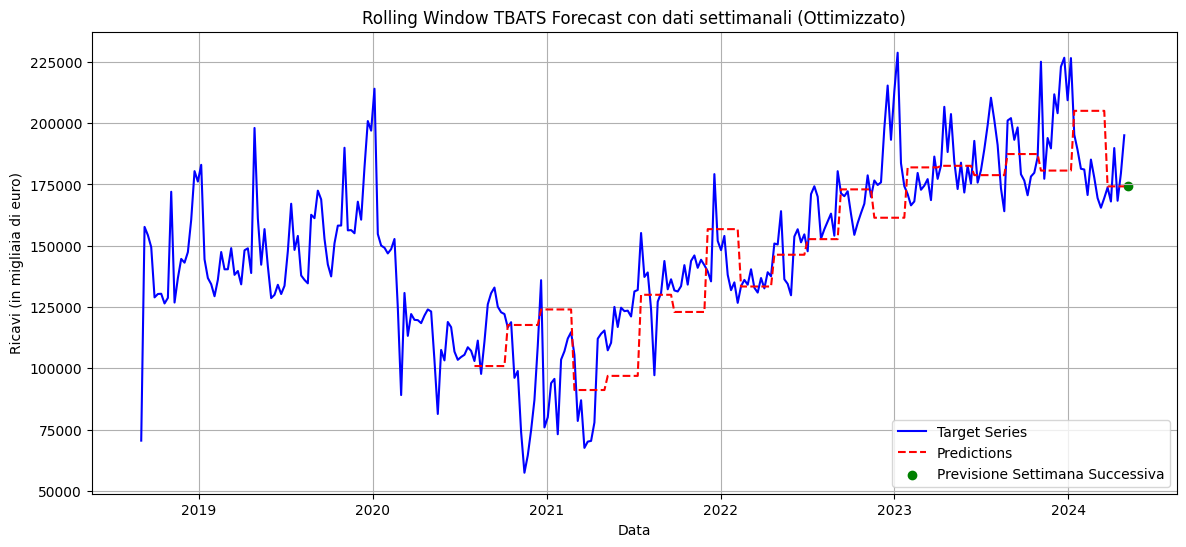

In [ ]:
from tbats import TBATS


warnings.filterwarnings("ignore")

def calculate_rmse_mape(true_values, predictions):
    rmse = np.sqrt(mean_squared_error(true_values, predictions))

    mask = true_values != 0
    if mask.sum() == 0:
        mape = np.inf
    else:
        mape = np.mean(np.abs((true_values[mask] - predictions[mask]) / true_values[mask])) * 100

    return round(rmse, 2), round(mape, 2) if mape is not None else None

file_path = '/content/drive/MyDrive/Progetto/output_df/FINALI SETTIMANALI/rist1_final.csv'
weekly_data_cleaned = pd.read_csv(file_path, index_col='data', parse_dates=True)

weekly_data_cleaned.index = pd.to_datetime(weekly_data_cleaned.index)
weekly_data_cleaned = weekly_data_cleaned.asfreq('W-SUN')

target_column = 'totale'

rolling_window_size = 100

tbats_estimator = TBATS(
    seasonal_periods=[52],
    use_box_cox=False,
    use_trend=False,
    use_damped_trend=False
)

tbats_model = None
predictions = []
true_values = []

for i in range(rolling_window_size, len(weekly_data_cleaned)):
    train_data = weekly_data_cleaned[:i]


    if tbats_model is None or i % 10 == 0:
        tbats_model = tbats_estimator.fit(train_data[target_column])

    pred = tbats_model.forecast(steps=1)
    predictions.append(pred[0])
    true_values.append(weekly_data_cleaned[target_column].iloc[i])

predictions_series = pd.Series(predictions, index=weekly_data_cleaned.index[rolling_window_size:])
true_values_series = pd.Series(true_values, index=weekly_data_cleaned.index[rolling_window_size:])

rmse, mape = calculate_rmse_mape(true_values_series, predictions_series)

# Mostriamo RMSE e MAPE
print(f"RMSE: {rmse}")
print(f"MAPE: {mape}%")

# Prevediamo la settimana successiva (dal 29/04/2024 al 05/05/2024)
next_week_index = pd.date_range(start='2024-04-29', end='2024-05-05', freq='W-SUN')
next_week_prediction = tbats_model.forecast(steps=1)

# Stampiamo la previsione per la settimana successiva
print(f"Previsione per la settimana {next_week_index[0].strftime('%Y-%m-%d')} - {next_week_index[-1].strftime('%Y-%m-%d')}: {next_week_prediction[0]}")

# Visualizzazione dei risultati
plt.figure(figsize=(14, 6))

# Tracciamo la serie reale (Target Series)
plt.plot(weekly_data_cleaned.index, weekly_data_cleaned[target_column], label='Target Series', color='blue', linestyle='-', linewidth=1.5)

# Tracciamo le previsioni (Predictions)
plt.plot(predictions_series.index, predictions_series, label='Predictions', linestyle='--', color='red', linewidth=1.5)

# Aggiungiamo la previsione della settimana successiva
plt.scatter(next_week_index[0], next_week_prediction[0], color='green', label='Previsione Settimana Successiva')

# Titolo del grafico
plt.title("Rolling Window TBATS Forecast con dati settimanali (Ottimizzato)")
plt.xlabel('Data')
plt.ylabel('Ricavi (in migliaia di euro)')

# Aggiungiamo la griglia
plt.grid(True)

# Aggiungiamo la legenda
plt.legend()

# Mostra il grafico
plt.show()


Apply pipeline TBATS on all resturants

In [ ]:

warnings.filterwarnings("ignore")

# Funzione per calcolare RMSE e MAPE con arrotondamento a due cifre decimali
def calculate_rmse_mape(true_values, predictions):
    rmse = np.sqrt(mean_squared_error(true_values, predictions))

    # Escludiamo i valori target uguali a 0 dal calcolo del MAPE
    mask = true_values != 0
    if mask.sum() == 0:
        mape = np.inf  # Se non ci sono valori diversi da 0
    else:
        mape = np.mean(np.abs((true_values[mask] - predictions[mask]) / true_values[mask])) * 100

    return round(rmse, 2), round(mape, 2) if mape is not None else None

# Percorso alla cartella contenente i file
directory = '/content/drive/MyDrive/Progetto/output_df/FINALI SETTIMANALI/'

# Liste per salvare i risultati di RMSE e MAPE per ogni ristorante
rmse_list = []
mape_list = []

# Iteriamo su tutti i file CSV nella directory
for filename in os.listdir(directory):
    if filename.endswith(".csv"):
        file_path = os.path.join(directory, filename)

        # Carichiamo i dati dal file
        weekly_data_cleaned = pd.read_csv(file_path, index_col='data', parse_dates=True)

        # Aggiungiamo la frequenza settimanale ai dati
        weekly_data_cleaned.index = pd.to_datetime(weekly_data_cleaned.index)
        weekly_data_cleaned = weekly_data_cleaned.asfreq('W-SUN')

        # Selezioniamo la variabile target
        target_column = 'totale'

        # Definiamo la finestra di rolling window
        rolling_window_size = 100

        # Inizializziamo TBATS con stagionalità settimanale (52 settimane)
        tbats_estimator = TBATS(
            seasonal_periods=[52],
            use_box_cox=False,   # Non applichiamo la trasformazione di Box-Cox
            use_trend=False,     # Disabilitiamo il trend per semplicità
            use_damped_trend=False
        )

        tbats_model = None
        predictions = []
        true_values = []

        # Ciclo di previsione con aggiornamento del modello ogni 10 iterazioni
        for i in range(rolling_window_size, len(weekly_data_cleaned)):
            train_data = weekly_data_cleaned[:i]

            # Aggiorniamo il modello TBATS ogni 10 iterazioni per migliorare le prestazioni
            if tbats_model is None or i % 10 == 0:
                tbats_model = tbats_estimator.fit(train_data[target_column])

            # Previsione con un passo avanti
            pred = tbats_model.forecast(steps=1)
            predictions.append(pred[0])
            true_values.append(weekly_data_cleaned[target_column].iloc[i])

        # Convertiamo le previsioni in una serie
        predictions_series = pd.Series(predictions, index=weekly_data_cleaned.index[rolling_window_size:])
        true_values_series = pd.Series(true_values, index=weekly_data_cleaned.index[rolling_window_size:])

        # Calcoliamo RMSE e MAPE
        rmse, mape = calculate_rmse_mape(true_values_series, predictions_series)

        # Aggiungiamo i risultati alla lista
        rmse_list.append(rmse)
        mape_list.append(mape)

        # Stampiamo i risultati per il ristorante corrente
        print(f"Ristorante: {filename} - RMSE: {rmse}, MAPE: {mape}%")

# Calcoliamo la media di RMSE e MAPE per tutti i ristoranti
mean_rmse = np.mean(rmse_list)
mean_mape = np.mean(mape_list)

# Stampiamo i risultati finali medi
print(f"\nRMSE medio per tutti i ristoranti: {mean_rmse}")
print(f"MAPE medio per tutti i ristoranti: {mean_mape}%")


Ristorante: rist3_final.csv - RMSE: 15137.35, MAPE: 11.72%
Ristorante: rist1_final.csv - RMSE: 21186.91, MAPE: 12.55%
Ristorante: rist4_final.csv - RMSE: 19424.15, MAPE: 9.16%
Ristorante: rist5_final.csv - RMSE: 19399.86, MAPE: 9.08%
Ristorante: rist2_final.csv - RMSE: 39697.79, MAPE: 9.36%

RMSE medio per tutti i ristoranti: 22969.212
MAPE medio per tutti i ristoranti: 10.374%


# HOLT WINTERS

In [ ]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import os
from google.colab import drive
drive.mount('/content/drive')
from prophet import Prophet
from prophet.diagnostics import cross_validation, performance_metrics
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error
from statsmodels.tsa.holtwinters import ExponentialSmoothing
import warnings


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
file_path = '/content/drive/MyDrive/Progetto/output_df/FINALI/rist1_final.csv'
data = pd.read_csv(file_path)

RMSE: 4897.41
MAPE: 17.61%


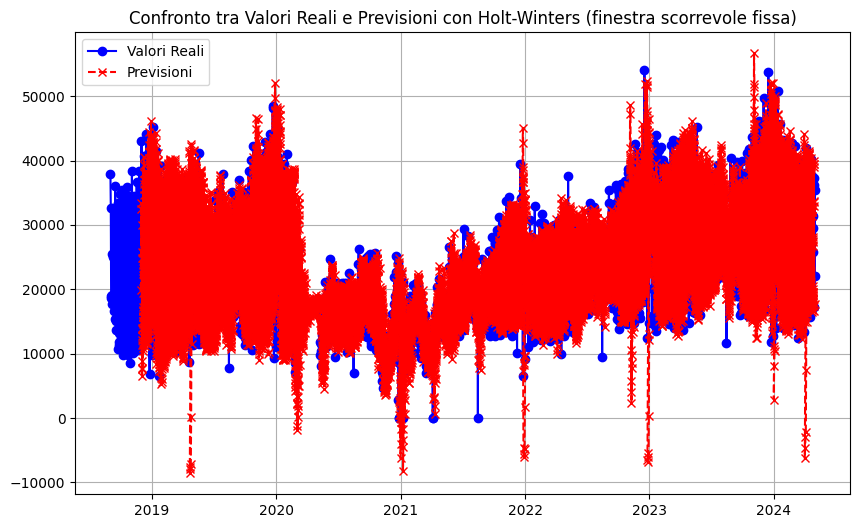

Previsioni per il periodo dal 02/05/2024 al 08/05/2024:
             ds          yhat
2062 2024-05-02  19150.086245
2063 2024-05-03  19137.414735
2064 2024-05-04  27328.605283
2065 2024-05-05  39425.169388
2066 2024-05-06  33628.228325
2067 2024-05-07  17348.748628
2068 2024-05-08  17685.007733


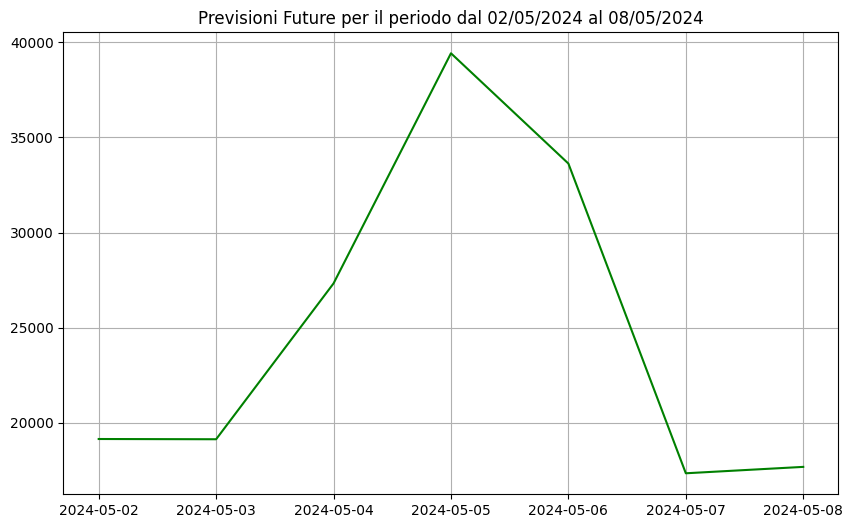

In [ ]:
warnings.filterwarnings("ignore")

def calculate_rmse_mape(true_values, predictions):
    rmse = np.sqrt(mean_squared_error(true_values, predictions))

    true_values = np.array(true_values)
    predictions = np.array(predictions)

    non_zero_indices = true_values != 0
    true_values_non_zero = true_values[non_zero_indices]
    predictions_non_zero = predictions[non_zero_indices]

    if len(true_values_non_zero) == 0:
        mape = np.nan
    else:
        mape = np.mean(np.abs((true_values_non_zero - predictions_non_zero) / true_values_non_zero)) * 100

    return round(rmse, 2), round(mape, 2)


def rolling_window_holt_winters_fixed(train_df: pd.DataFrame, full_data: pd.DataFrame, window_size: int = 90):
    """
    Implementa Holt-Winters con finestra fissa (rolling window) e prevede un intervallo di giorni.
    ---
    Args:
        train_df (pd.DataFrame): Dataset di training iniziale.
        full_data (pd.DataFrame): Dataset completo per generare previsioni future.
        window_size (int): Dimensione della finestra di rolling fissa.

    Returns: None
    """
    predictions = []
    true_values = []
    prediction_dates = []

    if len(full_data) < window_size:
        raise ValueError("Il dataset è troppo piccolo per la finestra di rolling specificata.")

    for t in range(window_size, len(full_data) - 7):
        # fixed window
        window_data = full_data[t-window_size:t].copy()

        model = ExponentialSmoothing(window_data['y'],
                                     seasonal_periods=7,  # weekly seasonality
                                     trend='add',
                                     seasonal='add')

        fitted_model = model.fit()

        forecast = fitted_model.forecast(steps=7) #Predict for 7 days

        predictions.extend(forecast)
        prediction_dates.extend(full_data['ds'].iloc[t:t+7].values)  # Days of predict
        true_values.extend(full_data['y'].iloc[t:t+7].values)  # Values of predict

    predictions_series = pd.Series(predictions, index=prediction_dates)
    true_values_series = pd.Series(true_values, index=prediction_dates)

    # Computing RMSE and MAPE
    rmse, mape = calculate_rmse_mape(np.array(true_values), np.array(predictions))
    print(f'RMSE: {rmse}')
    print(f'MAPE: {mape}%')

    # Plot
    plt.figure(figsize=(10, 6))
    plt.plot(full_data['ds'], full_data['y'], label='Valori Reali', marker='o', color='blue')
    plt.plot(predictions_series.index, predictions_series, label='Previsioni', linestyle='--', marker='x', color='red')
    plt.title('Confronto tra Valori Reali e Previsioni con Holt-Winters (finestra scorrevole fissa)')
    plt.legend()
    plt.grid()
    plt.show()

    # Prediction
    steps_ahead = (pd.to_datetime('2024-05-08') - full_data['ds'].max()).days
    future_forecast = fitted_model.forecast(steps=steps_ahead)


    future_period = pd.date_range(start=full_data['ds'].max() + pd.Timedelta(days=1), periods=steps_ahead)
    future_df = pd.DataFrame({'ds': future_period, 'yhat': future_forecast})

    print("Previsioni per il periodo dal 02/05/2024 al 08/05/2024:")
    print(future_df)

    # Plot predict
    plt.figure(figsize=(10, 6))
    plt.plot(future_df['ds'], future_df['yhat'], label='Previsioni Future', color='green')
    plt.title('Previsioni Future per il periodo dal 02/05/2024 al 08/05/2024')
    plt.grid()
    plt.show()


#Preparing data for the model
data['data'] = pd.to_datetime(data['data'])  # Conversione della colonna delle date
holtwinters_data = data[['data', 'totale']].rename(columns={'data': 'ds', 'totale': 'y'})
holtwinters_data.dropna(inplace=True)

train_data = holtwinters_data[:90]
full_data = holtwinters_data

rolling_window_holt_winters_fixed(train_df=train_data, full_data=full_data, window_size=90)


In [ ]:

warnings.filterwarnings("ignore")

# Funzione per calcolare RMSE e MAPE
def calculate_rmse_mape(true_values, predictions):
    rmse = np.sqrt(mean_squared_error(true_values, predictions))

    true_values = np.array(true_values)
    predictions = np.array(predictions)

    non_zero_indices = true_values != 0
    true_values_non_zero = true_values[non_zero_indices]
    predictions_non_zero = predictions[non_zero_indices]

    if len(true_values_non_zero) == 0:
        mape = np.nan
    else:
        mape = np.mean(np.abs((true_values_non_zero - predictions_non_zero) / true_values_non_zero)) * 100

    return round(rmse, 2), round(mape, 2)

# Funzione per applicare Holt-Winters con finestra fissa (rolling window)
def rolling_window_holt_winters_fixed(full_data: pd.DataFrame, window_size: int = 90):
    predictions = []
    true_values = []
    prediction_dates = []

    if len(full_data) < window_size:
        raise ValueError("Il dataset è troppo piccolo per la finestra di rolling specificata.")

    for t in range(window_size, len(full_data) - 7):
        window_data = full_data[t-window_size:t].copy()

        model = ExponentialSmoothing(window_data['y'],
                                     seasonal_periods=7,
                                     trend='add',
                                     seasonal='add')

        fitted_model = model.fit()

        forecast = fitted_model.forecast(steps=7)

        predictions.extend(forecast)
        prediction_dates.extend(full_data['ds'].iloc[t:t+7].values)
        true_values.extend(full_data['y'].iloc[t:t+7].values)

    predictions_series = pd.Series(predictions, index=prediction_dates)
    true_values_series = pd.Series(true_values, index=prediction_dates)

    rmse, mape = calculate_rmse_mape(np.array(true_values), np.array(predictions))

    return rmse, mape

# Liste per raccogliere RMSE e MAPE per ogni ristorante
rmse_list = []
mape_list = []
ristorante_results = []

# Percorso della cartella contenente i file CSV
folder_path = '/content/drive/MyDrive/Progetto/output_df/FINALI'

# Loop su ogni ristorante (file CSV)
for file_name in os.listdir(folder_path):
    if file_name.endswith('.csv'):
        file_path = os.path.join(folder_path, file_name)
        print(f"Elaborazione del file: {file_name}")

        data = pd.read_csv(file_path)

        data['data'] = pd.to_datetime(data['data'])
        holtwinters_data = data[['data', 'totale']].rename(columns={'data': 'ds', 'totale': 'y'})
        holtwinters_data.dropna(inplace=True)

        # Calcola RMSE e MAPE per il ristorante attuale
        rmse, mape = rolling_window_holt_winters_fixed(holtwinters_data)

        # Aggiungi i risultati alla lista
        rmse_list.append(rmse)
        mape_list.append(mape)
        ristorante_results.append({
            'Ristorante': file_name,
            'RMSE': rmse,
            'MAPE': mape
        })

# Stampa i risultati per ogni ristorante
print("\nRisultati per ciascun ristorante:")
for result in ristorante_results:
    print(f"Ristorante: {result['Ristorante']}, RMSE: {result['RMSE']}, MAPE: {result['MAPE']}%")

# Calcola e stampa la media di RMSE e MAPE su tutti i file
mean_rmse = np.mean(rmse_list)
mean_mape = np.mean(mape_list)

print(f"\nMedia RMSE su tutti i file: {round(mean_rmse, 2)}")
print(f"Media MAPE su tutti i file: {round(mean_mape, 2)}%")


Elaborazione del file: rist3_final.csv
Elaborazione del file: rist1_final.csv
Elaborazione del file: rist5_final.csv
Elaborazione del file: rist4_final.csv
Elaborazione del file: rist2_final.csv

Risultati per ciascun ristorante:
Ristorante: rist3_final.csv, RMSE: 3321.11, MAPE: 23.15%
Ristorante: rist1_final.csv, RMSE: 4897.41, MAPE: 17.61%
Ristorante: rist5_final.csv, RMSE: 3899.5, MAPE: 12.53%
Ristorante: rist4_final.csv, RMSE: 4081.31, MAPE: 11.84%
Ristorante: rist2_final.csv, RMSE: 6123.97, MAPE: 12.3%

Media RMSE su tutti i file: 4464.66
Media MAPE su tutti i file: 15.49%


# PROPHET

In [ ]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import os
from google.colab import drive
drive.mount('/content/drive')
from prophet import Prophet
from prophet.diagnostics import cross_validation, performance_metrics
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_absolute_percentage_error
import warnings
import logging


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
file_path = '/content/drive/MyDrive/Progetto/output_df/FINALI/rist1_final.csv'
data = pd.read_csv(file_path)

Apply pipeline PROPHET only on first resturant

RMSE: 6596.945689354704
MAPE: 18.234732125388557%

Previsioni per i prossimi 7 giorni:
            ds          yhat
53 2024-05-02  31888.426472
54 2024-05-03  36960.756414
55 2024-05-04  44267.359812
56 2024-05-05  36036.131775
57 2024-05-06  24888.500024
58 2024-05-07  29808.602280
59 2024-05-08  31517.696924


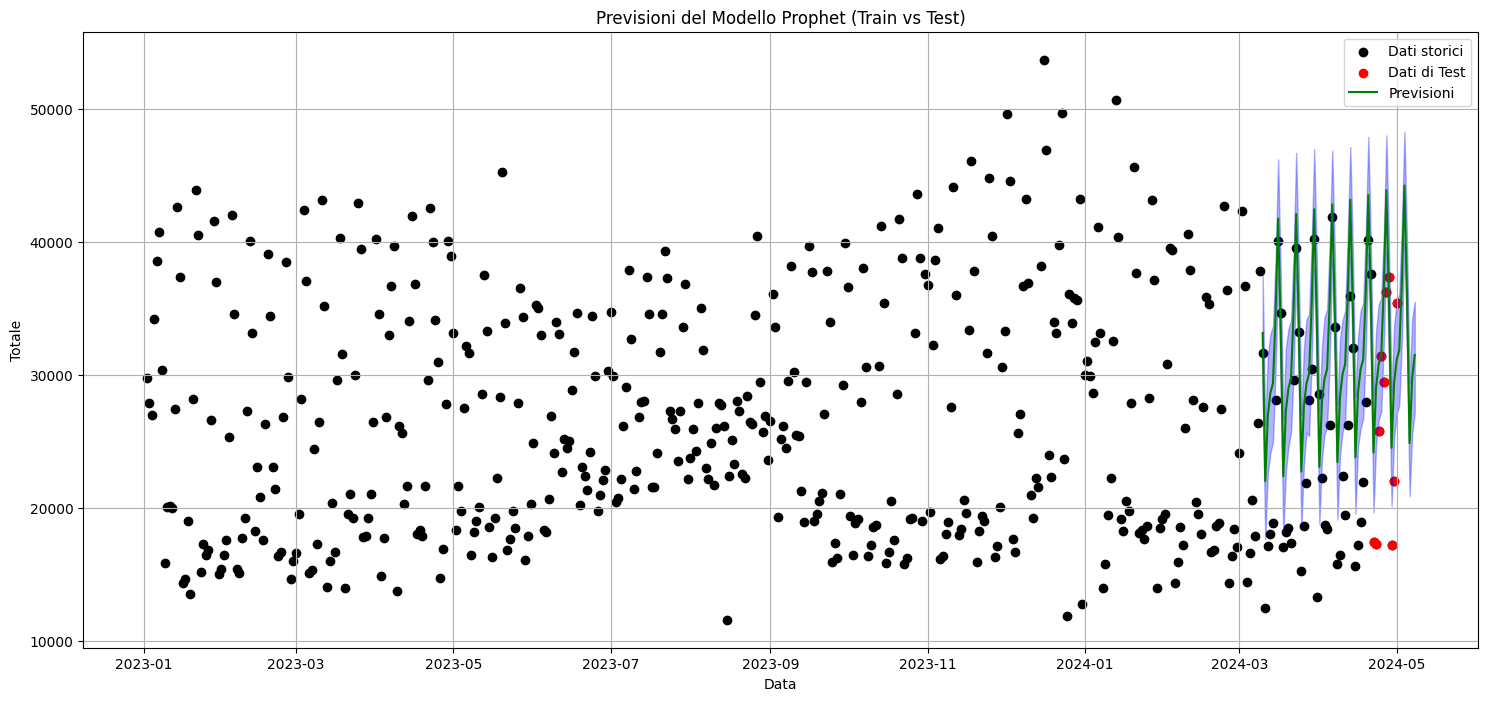

In [ ]:
import numpy as np
import pandas as pd
from prophet import Prophet
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error
import matplotlib.pyplot as plt
import warnings
import logging

warnings.filterwarnings("ignore")
logging.getLogger('cmdstanpy').setLevel(logging.ERROR)
logging.getLogger('prophet').setLevel(logging.ERROR)

def rolling_window_prophet_with_plots(train_df: pd.DataFrame, test_df: pd.DataFrame, exog_vars: list = None, window_size: int = 52):
    """
    Implementa Prophet con finestra di rolling per previsioni e plotti i risultati.
    ---
    Args:
        train_df (pd.DataFrame): Dataset di training.
        test_df (pd.DataFrame): Dataset di test.
        exog_vars (list): Lista di variabili esogene.
        window_size (int): Dimensione della finestra di rolling.

    Returns: None
    """

    history = train_df.copy()
    predictions = []

    for t in range(len(test_df)):
        window_data = history[-window_size:].copy()

        model = Prophet()

        # Exogenous variables
        if exog_vars:
            for var in exog_vars:
                model.add_regressor(var)

        model.fit(window_data)

        future = pd.DataFrame({'ds': [test_df.iloc[t]['ds']]})

        if exog_vars:
            for var in exog_vars:
                future[var] = test_df.iloc[t][var]

        forecast = model.predict(future)
        predictions.append(forecast['yhat'].values[0])

        history = pd.concat([history, test_df.iloc[[t]]])

    test_actual = test_df['y'].values
    mse = mean_squared_error(test_actual, predictions)
    rmse = np.sqrt(mse)
    mape = mean_absolute_percentage_error(test_actual, predictions) * 100

    print(f'RMSE: {rmse}')
    print(f'MAPE: {mape}%')

    forecast_df = pd.DataFrame({'Actual': test_actual, 'Forecast': predictions}, index=test_df['ds'])

    # Limit data for visualization to the last 2 years
    history_filtered = history[history['ds'] > '2023-01-01']

    # Plotting the train and test forecast
    future_7_days = model.make_future_dataframe(periods=8, freq='D')

    if exog_vars:
        for var in exog_vars:
            future_7_days[var] = train_df[var].values[-1]
    forecast_future = model.predict(future_7_days)

    future_predictions = forecast_future[['ds', 'yhat']].tail(7)
    print("\nPrevisioni per i prossimi 7 giorni:\n", future_predictions)

    # Plot results
    plt.figure(figsize=(18, 8))

    # Plot the filtered historical data (last 2 years)
    plt.scatter(history_filtered['ds'], history_filtered['y'], color='black', label='Dati storici')
    plt.scatter(test_df['ds'], test_df['y'], color='red', label='Dati di Test')

    # Plot the forecast
    plt.plot(forecast_future['ds'], forecast_future['yhat'], label='Previsioni', color='green')

    # Plot uncertainty intervals
    plt.fill_between(forecast_future['ds'], forecast_future['yhat_lower'], forecast_future['yhat_upper'], color='blue', alpha=0.3)

    plt.title('Previsioni del Modello Prophet (Train vs Test)')
    plt.xlabel('Data')
    plt.ylabel('Totale')
    plt.legend()
    plt.grid(True)
    plt.show()

# Preparing the data
data['data'] = pd.to_datetime(data['data'])
prophet_data = data[['data', 'totale']].rename(columns={'data': 'ds', 'totale': 'y'})

# Exogenous variables
exog_variables = ['TMEDIA °C', 'partite giornaliere', 'champions', 'atm_cond']

prophet_data['TMEDIA °C'] = data['TMEDIA °C']
prophet_data['partite giornaliere'] = data['partite giornaliere']
prophet_data['champions'] = data['champions']
prophet_data['atm_cond'] = data['atm_cond']

# Split test and train
train_data = prophet_data[:-10]
test_data = prophet_data[-10:]

# Run the rolling window Prophet model and plot the results
rolling_window_prophet_with_plots(train_df=train_data, test_df=test_data, exog_vars=exog_variables, window_size=52)


In [ ]:

warnings.filterwarnings("ignore")
logging.getLogger('cmdstanpy').setLevel(logging.ERROR)
logging.getLogger('prophet').setLevel(logging.ERROR)

def calculate_rmse_mape(true_values, predictions):
    rmse = np.sqrt(mean_squared_error(true_values, predictions))

    true_values = np.array(true_values)
    predictions = np.array(predictions)

    non_zero_indices = true_values != 0
    true_values_non_zero = true_values[non_zero_indices]
    predictions_non_zero = predictions[non_zero_indices]

    if len(true_values_non_zero) == 0:
        mape = np.nan
    else:
        mape = np.mean(np.abs((true_values_non_zero - predictions_non_zero) / true_values_non_zero)) * 100

    return round(rmse, 2), round(mape, 2)

def rolling_window_prophet(train_df: pd.DataFrame, test_df: pd.DataFrame, exog_vars: list = None, window_size: int = 52, ristorante_name: str = ''):
    """
    Implementa Prophet con finestra di rolling per previsioni e raccoglie RMSE e MAPE.
    ---
    Args:
        train_df (pd.DataFrame): Dataset di training.
        test_df (pd.DataFrame): Dataset di test.
        exog_vars (list): Lista di variabili esogene.
        window_size (int): Dimensione della finestra di rolling.
        ristorante_name (str): Nome del ristorante (per salvare i grafici).

    Returns:
        rmse (float): Root Mean Squared Error.
        mape (float): Mean Absolute Percentage Error.
    """

    history = train_df.copy()
    predictions = []
    forecast_dfs = []

    for t in range(len(test_df)):
        window_data = history[-window_size:].copy()

        model = Prophet()

        if exog_vars:
            for var in exog_vars:
                model.add_regressor(var)

        model.fit(window_data)

        future = pd.DataFrame({'ds': [test_df.iloc[t]['ds']]})

        if exog_vars:
            for var in exog_vars:
                future[var] = test_df.iloc[t][var]

        forecast = model.predict(future)
        predictions.append(forecast['yhat'].values[0])
        forecast_dfs.append(forecast)
        history = pd.concat([history, test_df.iloc[[t]]])

    forecast_full = pd.concat(forecast_dfs)

    test_actual = test_df['y'].values
    mse = mean_squared_error(test_actual, predictions)
    rmse = round(np.sqrt(mse), 2)  # Arrotondamento alla seconda cifra decimale
    mape = round(mean_absolute_percentage_error(test_actual, predictions) * 100, 2)  # Arrotondamento alla seconda cifra decimale

    return rmse, mape

def process_folder(directory_path: str):
    """
    Processa tutti i file CSV nella cartella specificata e raccoglie gli indicatori RMSE e MAPE per ciascun ristorante.
    ---
    Args:
        directory_path (str): Il percorso della cartella contenente i file CSV.

    Returns:
        results_df (pd.DataFrame): DataFrame contenente i risultati medi per ogni ristorante.
    """
    results = []
    rmse_list = []
    mape_list = []

    for file_name in os.listdir(directory_path):
        if file_name.endswith('.csv'):
            file_path = os.path.join(directory_path, file_name)

            data = pd.read_csv(file_path)

            data['data'] = pd.to_datetime(data['data'])

            prophet_data = data[['data', 'totale']].rename(columns={'data': 'ds', 'totale': 'y'})

            exog_variables = ['TMEDIA °C', 'partite giornaliere', 'champions', 'atm_cond']
            for var in exog_variables:
                if var in data.columns:
                    prophet_data[var] = data[var]

            train_data = prophet_data[:-10]
            test_data = prophet_data[-10:]

            rmse, mape = rolling_window_prophet(train_df=train_data, test_df=test_data, exog_vars=exog_variables, window_size=52, ristorante_name=file_name)

            # Aggiungiamo i valori di RMSE e MAPE alle liste
            rmse_list.append(rmse)
            mape_list.append(mape)

            results.append({
                'Ristorante': file_name,
                'RMSE': rmse,
                'MAPE': mape
            })

    results_df = pd.DataFrame(results)

    # Calcoliamo la media di RMSE e MAPE per tutti i ristoranti
    mean_rmse = round(np.mean(rmse_list), 2)  # Arrotondamento alla seconda cifra decimale
    mean_mape = round(np.mean(mape_list), 2)  # Arrotondamento alla seconda cifra decimale

    print(f"\nRMSE medio per tutti i ristoranti: {mean_rmse}")
    print(f"MAPE medio per tutti i ristoranti: {mean_mape}%")

    return results_df

# Specifica il percorso alla cartella contenente i file CSV
directory_path = '/content/drive/MyDrive/Progetto/output_df/FINALI/'

# Processiamo la cartella e raccogliamo i risultati
final_results = process_folder(directory_path)

# Stampa i risultati medi per ogni ristorante
print(final_results)



RMSE medio per tutti i ristoranti: 5654.0
MAPE medio per tutti i ristoranti: 13.84%
        Ristorante     RMSE   MAPE
0  rist3_final.csv  3407.45  11.44
1  rist1_final.csv  6596.95  18.23
2  rist5_final.csv  5192.42  12.87
3  rist4_final.csv  6190.55  15.89
4  rist2_final.csv  6882.61  10.77


## CONSIDERATION ON THE ANALYSIS

The following analyses were conducted:

- Creation of 2 models with data aggregated weekly (for computational reasons): SARIMAX and TBATS. The first uses external regressors, and the second does not. Both models use an expanding rolling window method for cross-validation.
- Creation of 2 additional models with daily data: PROPHET and HOLT-WINTERS. As with the weekly models, the first uses external regressors and the second does not. A fixed rolling window method is used for cross-validation.

The objective is to determine which model performs best by comparing RMSE and MAPE, evaluate which is more efficient from a computational perspective, and assess whether the impact of the external regressors is significant.

Explanation cross validation methods

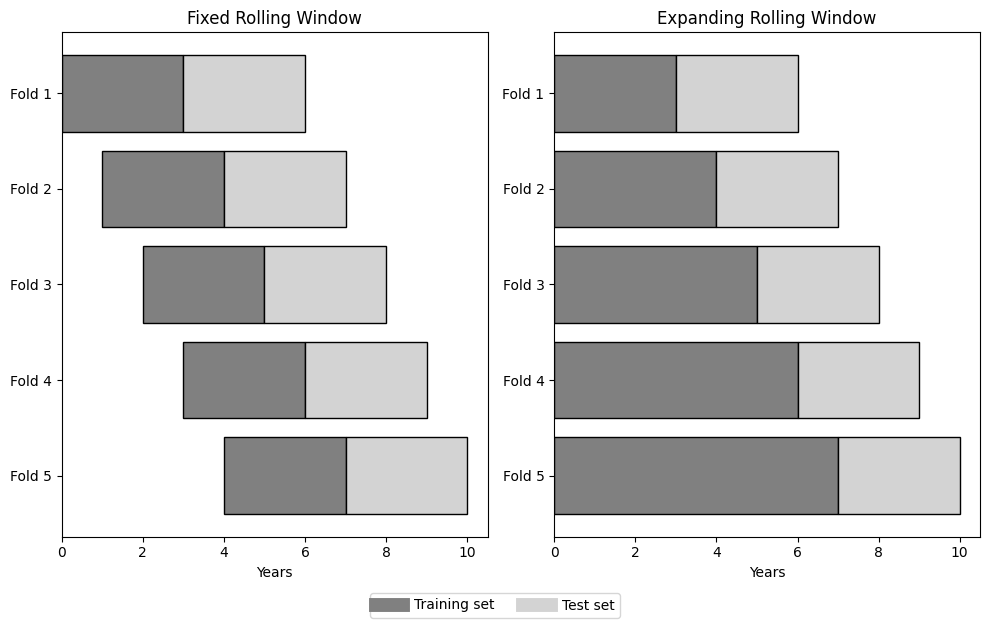

In [ ]:
#SPIEGAZIONE METODI DI CROSS VALIDATION



def plot_rolling_windows():
    fig, ax = plt.subplots(1, 2, figsize=(10, 6))

    for i in range(5):
        ax[0].barh(y=i, width=3, left=i, color='gray', edgecolor='black')
        ax[0].barh(y=i, width=3, left=i + 3, color='lightgray', edgecolor='black')

    ax[0].set_yticks(range(5))
    ax[0].set_yticklabels([f'Fold {i+1}' for i in range(5)])
    ax[0].set_xlabel('Years')
    ax[0].set_title('Fixed Rolling Window')
    ax[0].invert_yaxis()

    for i in range(5):
        ax[1].barh(y=i, width=i+3, left=0, color='gray', edgecolor='black')
        ax[1].barh(y=i, width=3, left=i+3, color='lightgray', edgecolor='black')

    ax[1].set_yticks(range(5))
    ax[1].set_yticklabels([f'Fold {i+1}' for i in range(5)])
    ax[1].set_xlabel('Years')
    ax[1].set_title('Expanding Rolling Window')
    ax[1].invert_yaxis()

    gray_patch = plt.Line2D([0], [0], color='gray', lw=10, label='Training set')
    lightgray_patch = plt.Line2D([0], [0], color='lightgray', lw=10, label='Test set')
    fig.legend(handles=[gray_patch, lightgray_patch], loc='lower center', ncol=2, bbox_to_anchor=(0.5, -0.05))

    plt.tight_layout()
    plt.show()

plot_rolling_windows()

## Fixed Rolling Window
**Description:**
In this method, the time window used to train the model has a fixed size. As you move through the data, this window is updated by discarding the oldest observations and adding the most recent ones, keeping the number of observations used for training constant.

**Process:**
1. Start:
Use the first n data points to train the model.
Predict the value for data point n+1.
2. Window Moves:
Discard the oldest data point (the 1st data point) and add the next one, forming a new window.
Predict the value for data point n+2.

This process continues until you have covered all the data.


## Expanding Rolling Window
**Description:**
In contrast to the fixed window method, here the window progressively expands by adding new observations without discarding the old ones. Thus, the size of the window grows over time, including more data as it advances.

**Process:**
1. Start:
Use the first n data points to train the model.
Predict the value for data point n+1.
2. Window Expands:
Retain the existing data and add the new ones.
Predict the value for data point n+2.

This process continues, progressively increasing the window size.

# RESULTS

Plot and comments **PROPHET** and **HOLT_WINTERS**

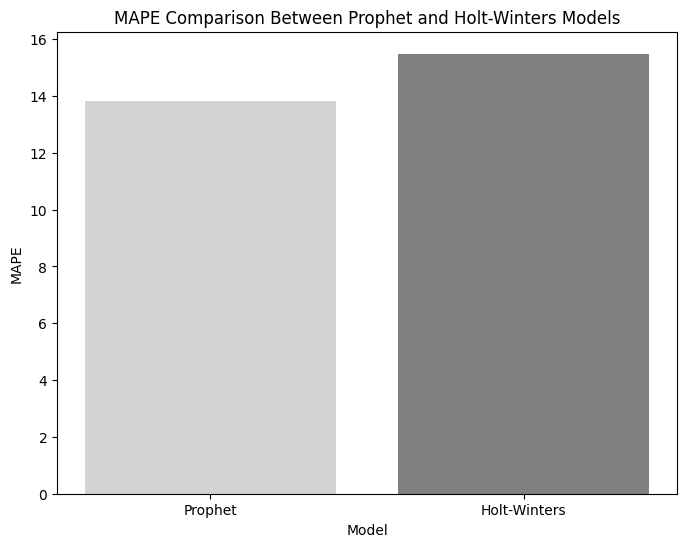

In [ ]:
models = ['Prophet', 'Holt-Winters']
mape_values = [13.84, 15.49]

plt.figure(figsize=(8,6))
plt.bar(models, mape_values, color=['lightgray', 'gray'])

plt.title('MAPE Comparison Between Prophet and Holt-Winters Models')
plt.xlabel('Model')
plt.ylabel('MAPE')

plt.show()


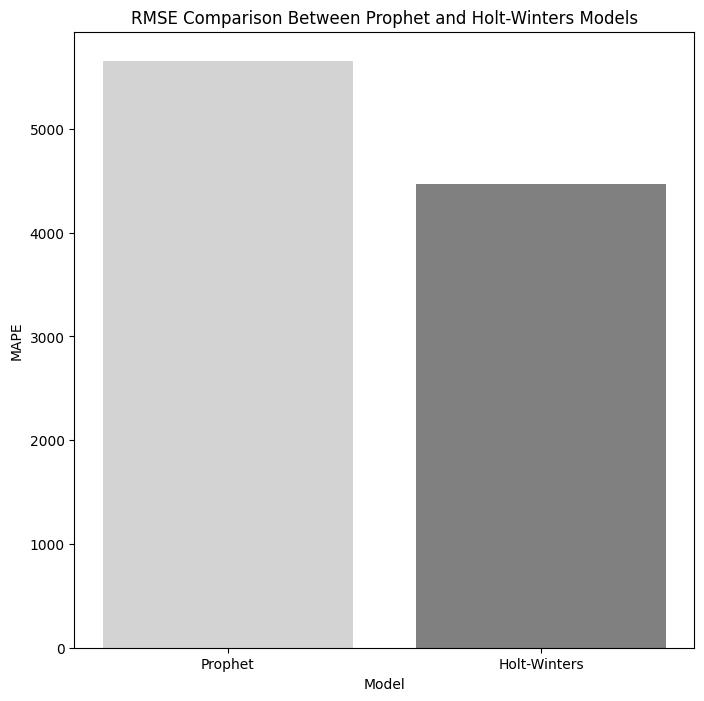

In [ ]:
models = ['Prophet', 'Holt-Winters']
mape_values = [5654, 4464.66]

plt.figure(figsize=(8,8))
plt.bar(models, mape_values, color=['lightgrey', 'grey'])

plt.title('RMSE Comparison Between Prophet and Holt-Winters Models')
plt.xlabel('Model')
plt.ylabel('RMSE')

plt.show()


The MAPE of the Prophet model is lower than that of Holt-Winters.
This means that, in percentage terms, the Prophet model makes fewer relative errors compared to Holt-Winters. In other words, Prophet tends to predict the behavior of the time series more accurately in relation to the actual values.

The RMSE of the Prophet model is higher than that of Holt-Winters.
RMSE measures errors in terms of absolute differences, so this suggests that while Prophet performs well in relative terms (MAPE), it has larger absolute errors, which could be due to outliers or less accurate predictions on large values.

Overall, it can be said that by better managing outliers, Prophet is likely to provide better results, even from a computational standpoint, as it is much faster. It seems, therefore, that the effect of the external regressors is positive.

Varianza RMSE Prophet: 1986641.5339799998
Varianza MAPE Prophet: 9.900100000000004
Varianza RMSE Holt-Winters: 1178662.9723
Varianza MAPE Holt-Winters: 23.857529999999997


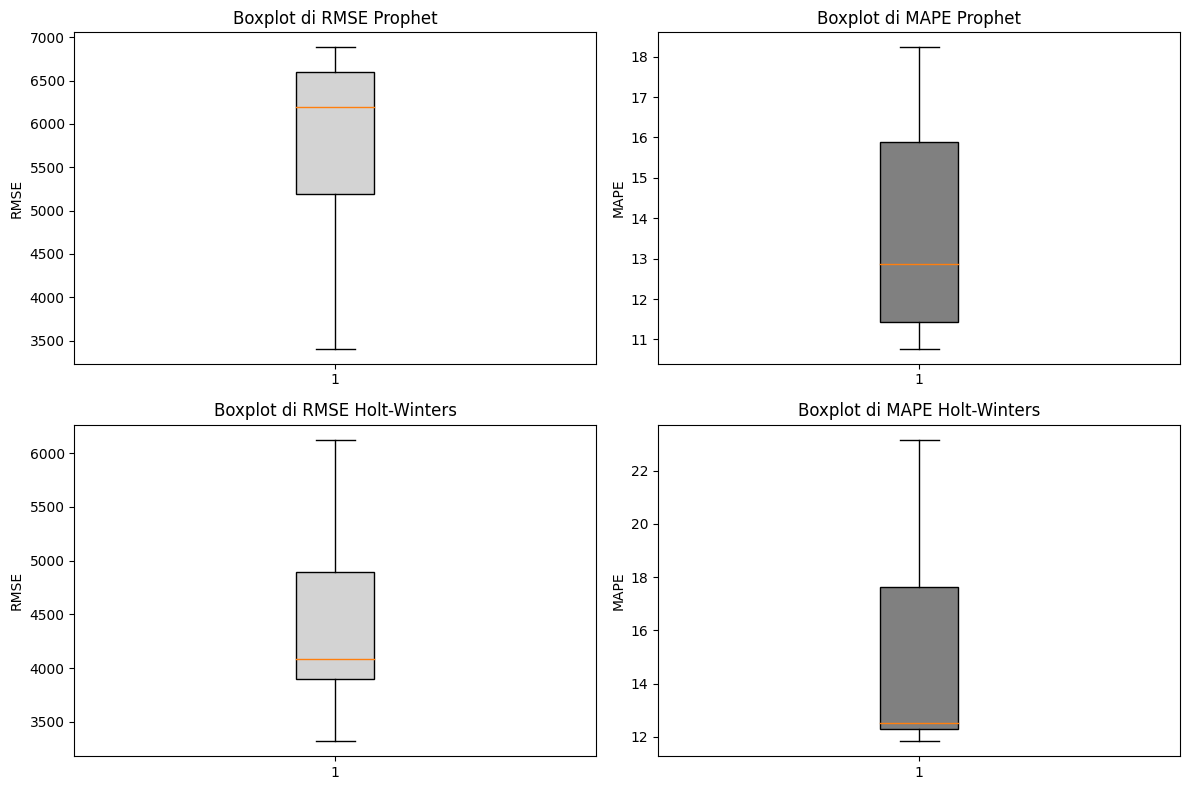

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

data_prophet = {
    'Ristorante': ['rist3_final.csv', 'rist1_final.csv', 'rist5_final.csv', 'rist4_final.csv', 'rist2_final.csv'],
    'RMSE': [3407.45, 6596.95, 5192.42, 6190.55, 6882.61],
    'MAPE': [11.44, 18.23, 12.87, 15.89, 10.77]
}

data_holt_winters = {
    'Ristorante': ['rist3_final.csv', 'rist1_final.csv', 'rist5_final.csv', 'rist4_final.csv', 'rist2_final.csv'],
    'RMSE': [3321.11, 4897.41, 3899.5, 4081.31, 6123.97],
    'MAPE': [23.15, 17.61, 12.53, 11.84, 12.3]
}

df_prophet = pd.DataFrame(data_prophet)
df_holt_winters = pd.DataFrame(data_holt_winters)

rmse_variance_prophet = np.var(df_prophet['RMSE'], ddof=1)
mape_variance_prophet = np.var(df_prophet['MAPE'], ddof=1)

rmse_variance_holt_winters = np.var(df_holt_winters['RMSE'], ddof=1)
mape_variance_holt_winters = np.var(df_holt_winters['MAPE'], ddof=1)

print(f'Varianza RMSE Prophet: {rmse_variance_prophet}')
print(f'Varianza MAPE Prophet: {mape_variance_prophet}')

print(f'Varianza RMSE Holt-Winters: {rmse_variance_holt_winters}')
print(f'Varianza MAPE Holt-Winters: {mape_variance_holt_winters}')

plt.figure(figsize=(12, 8))

# Boxplot per RMSE Prophet
plt.subplot(2, 2, 1)
plt.boxplot(df_prophet['RMSE'], patch_artist=True, boxprops=dict(facecolor='lightgrey'))
plt.title('Boxplot di RMSE Prophet')
plt.ylabel('RMSE')

# Boxplot per MAPE Prophet
plt.subplot(2, 2, 2)
plt.boxplot(df_prophet['MAPE'], patch_artist=True, boxprops=dict(facecolor='grey'))
plt.title('Boxplot di MAPE Prophet')
plt.ylabel('MAPE')

# Boxplot per RMSE Holt-Winters
plt.subplot(2, 2, 3)
plt.boxplot(df_holt_winters['RMSE'], patch_artist=True, boxprops=dict(facecolor='lightgrey'))
plt.title('Boxplot di RMSE Holt-Winters')
plt.ylabel('RMSE')

# Boxplot per MAPE Holt-Winters
plt.subplot(2, 2, 4)
plt.boxplot(df_holt_winters['MAPE'], patch_artist=True, boxprops=dict(facecolor='grey'))
plt.title('Boxplot di MAPE Holt-Winters')
plt.ylabel('MAPE')

plt.tight_layout()
plt.show()


**Prophet**

RMSE: The variance of RMSE for Prophet is relatively high (198.8641), indicating some variability in results across different restaurants. However, the range is more contained compared to Holt-Winters, with values ranging from about 3,500 to nearly 7,000.

MAPE: The variance of MAPE is quite low (9.90), with values distributed in a range from about 11% to 18%. Prophet shows greater consistency in MAPE values, although some restaurants have higher percentage errors than others.

**Holt-Winters**

RMSE: The variance of RMSE for Holt-Winters is slightly lower compared to Prophet (117.8662), with a range of values from about 3,500 to 6,000. This indicates that, despite the lower variance, Holt-Winters has a more homogeneous distribution of results across restaurants.

MAPE: The variance of MAPE is significantly higher (23.85) compared to Prophet, and the range of values is wider, varying from about 12% to over 23%. This suggests that Holt-Winters has more variable performance across different restaurants in terms of percentage accuracy.


RMSE: Prophet shows greater variance in results compared to Holt-Winters, but it has a narrower range. Holt-Winters, on the other hand, has a more consistent distribution but with slightly higher error values.

MAPE: Prophet has a more uniform distribution with lower MAPE values compared to Holt-Winters, which shows greater variability and higher values, particularly for some restaurants.


In **conclusion**, Prophet appears to be more consistent and produces more uniform results than Holt-Winters, especially in terms of percentage accuracy (MAPE). However, Holt-Winters can yield similar or better results in some cases when it comes to absolute error (RMSE).

**PLOT** **COMPARAZIONE** **PREDICTS**

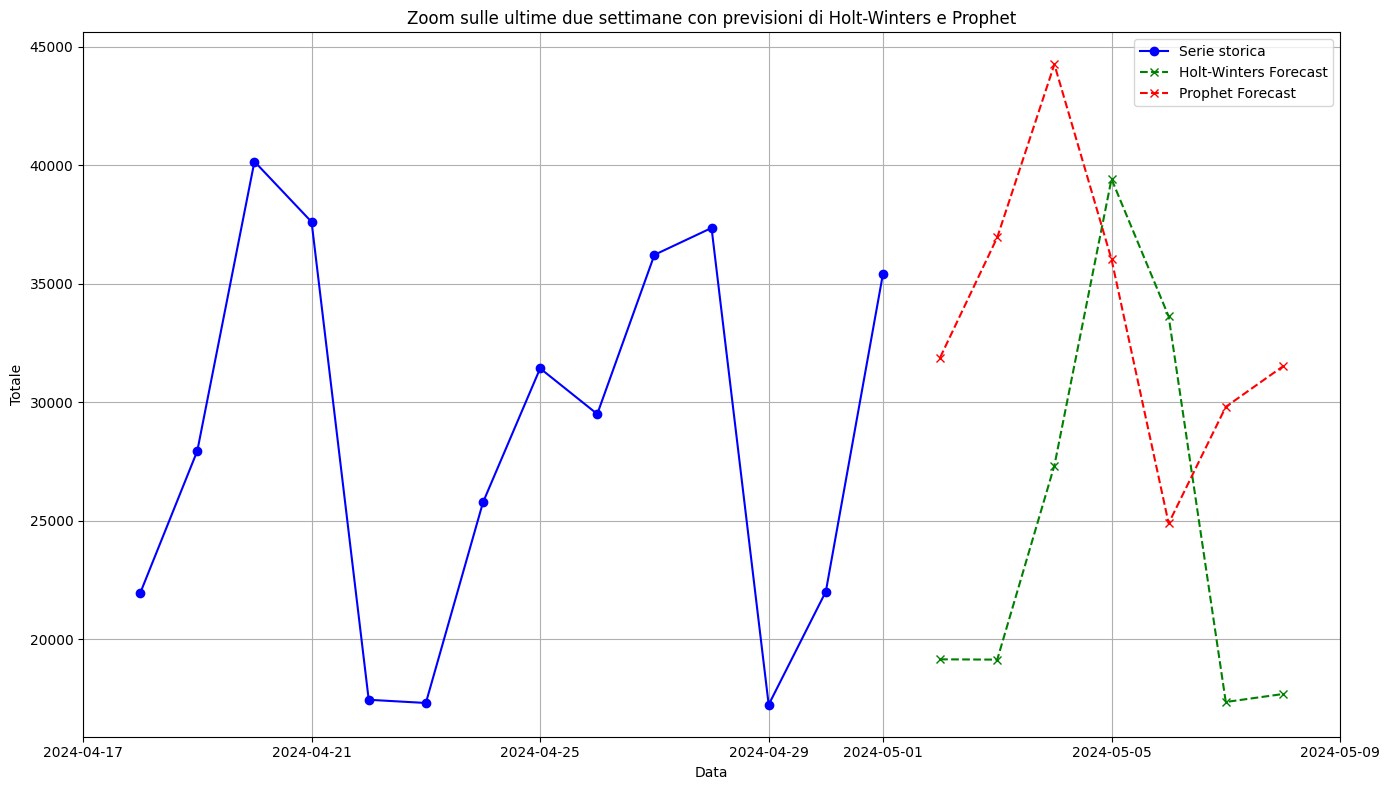

In [ ]:


holt_winters_forecast = {
    'Date': ['2024-05-02', '2024-05-03', '2024-05-04', '2024-05-05', '2024-05-06', '2024-05-07', '2024-05-08'],
    'Forecast': [19150.086245, 19137.414735, 27328.605283, 39425.169388, 33628.228325, 17348.748628, 17685.007733]
}

prophet_forecast = {
    'Date': ['2024-05-02', '2024-05-03', '2024-05-04', '2024-05-05', '2024-05-06', '2024-05-07', '2024-05-08'],
    'Forecast': [31888.426472, 36960.756414, 44267.359812, 36036.131775, 24888.500024, 29808.602280, 31517.696924]
}

df_holt_winters = pd.DataFrame(holt_winters_forecast)
df_prophet = pd.DataFrame(prophet_forecast)

df_holt_winters['Date'] = pd.to_datetime(df_holt_winters['Date'])
df_prophet['Date'] = pd.to_datetime(df_prophet['Date'])

historical_data_path = '/content/drive/MyDrive/Progetto/output_df/FINALI/rist1_final.csv'
historical_data = pd.read_csv(historical_data_path)

historical_data['data'] = pd.to_datetime(historical_data['data'])

historical_data_zoom = historical_data[historical_data['data'] >= '2024-04-18']

plt.figure(figsize=(14, 8))

plt.plot(historical_data_zoom['data'], historical_data_zoom['totale'], label='Serie storica', color='blue', marker='o')

# Previsioni Holt-Winters
plt.plot(df_holt_winters['Date'], df_holt_winters['Forecast'], label='Holt-Winters Forecast', color='green', linestyle='--', marker='x')

# Previsioni Prophet
plt.plot(df_prophet['Date'], df_prophet['Forecast'], label='Prophet Forecast', color='red', linestyle='--', marker='x')

plt.title('Zoom sulle ultime due settimane con previsioni di Holt-Winters e Prophet')
plt.xlabel('Data')
plt.ylabel('Totale')
plt.grid(True)
plt.legend()

plt.tight_layout()
plt.show()


Plot and comments on **SARIMAX** and **TBATS**

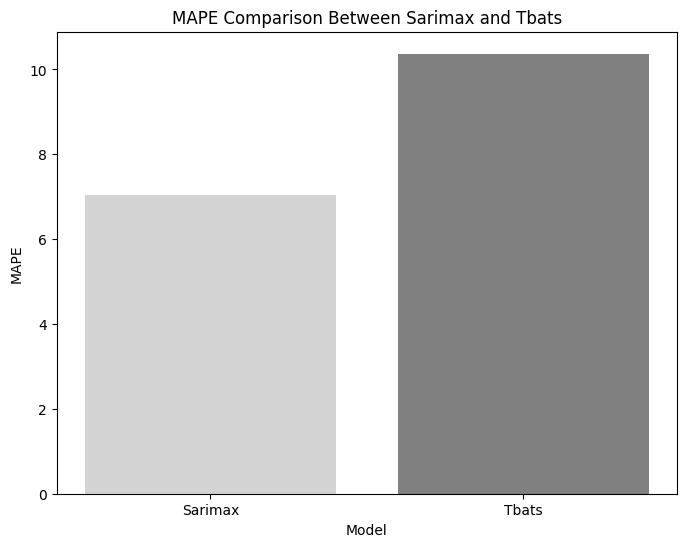

In [ ]:
models = ['Sarimax', 'Tbats']
mape_values = [7.03, 10.37]

plt.figure(figsize=(8,6))
plt.bar(models, mape_values, color=['lightgray', 'gray'])

plt.title('MAPE Comparison Between Sarimax and Tbats')
plt.xlabel('Model')
plt.ylabel('MAPE')

plt.show()

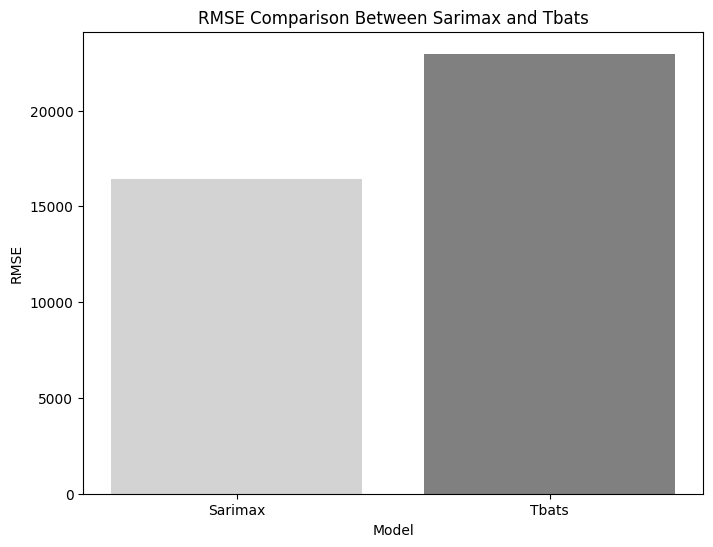

In [ ]:
models = ['Sarimax', 'Tbats']
mape_values = [16406.45, 22969.21]

plt.figure(figsize=(8,6))
plt.bar(models, mape_values, color=['lightgray', 'gray'])

plt.title('RMSE Comparison Between Sarimax and Tbats')
plt.xlabel('Model')
plt.ylabel('RMSE')

plt.show()

The **MAPE (Mean Absolute Percentage Error)** for SARIMAX is lower than that for TBATS. This indicates that, in terms of average percentage error, SARIMAX provides more accurate predictions compared to TBATS.
A lower MAPE for SARIMAX suggests that its predictions are relatively closer to the actual values compared to the TBATS model.

The **RMSE (Root Mean Squared Error)** for TBATS is higher than that for SARIMAX. This implies that the TBATS model has larger absolute errors compared to SARIMAX.
SARIMAX shows a lower RMSE, meaning it makes smaller absolute errors compared to TBATS.

**Comment on Results:**
SARIMAX seems to perform better both in terms of relative error (MAPE) and absolute error (RMSE). This suggests that the SARIMAX model is more precise in predicting both the percentage scale and the absolute differences between the predicted and actual values. It is clear that the impact of external regressors is consistently positive for improving the model's accuracy.

It can be said that generally, all models have good MAPE and RMSE scores, especially MAPE, which is below the 20% threshold. However, only SARIMAX achieves an excellent MAPE, being below the 10% threshold. It appears that models using the expanding rolling window tend to be more performant, although to be certain, they should be compared using the same distribution, i.e., all weekly or all daily data (unfortunately, due to computational constraints, this was not possible).


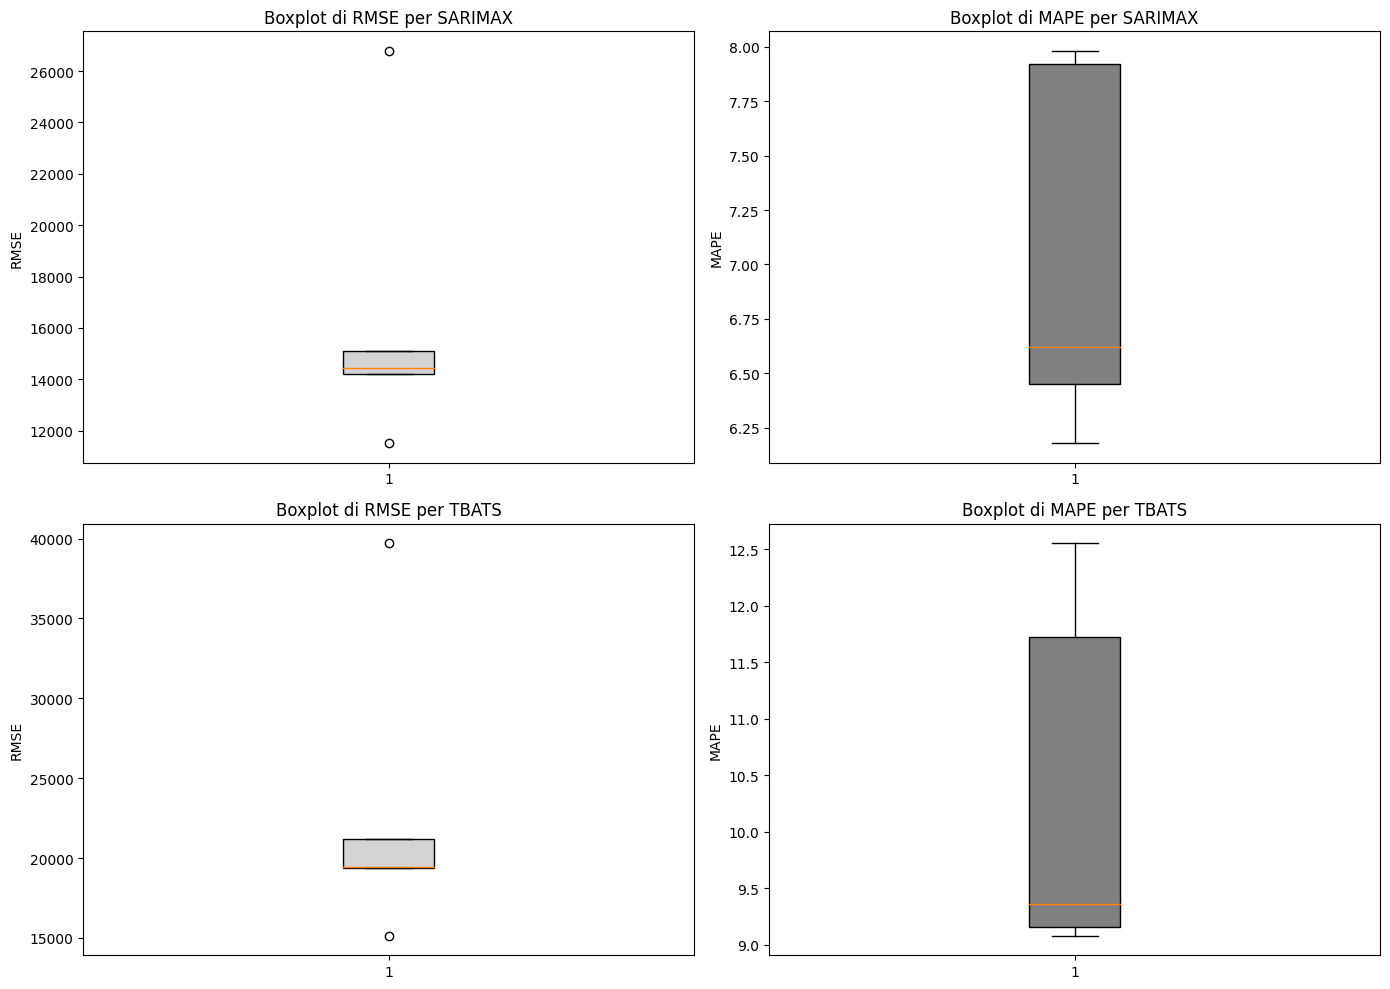

In [ ]:

# Dati SARIMAX
sarimax_data = {
    'Ristorante': ['rist3_final.csv', 'rist1_final.csv', 'rist4_final.csv', 'rist5_final.csv', 'rist2_final.csv'],
    'RMSE': [11509.51, 14443.09, 14197.53, 15095.26, 26786.89],
    'MAPE': [7.98, 7.92, 6.18, 6.45, 6.62]
}

# Dati TBATS
tbats_data = {
    'Ristorante': ['rist3_final.csv', 'rist1_final.csv', 'rist4_final.csv', 'rist5_final.csv', 'rist2_final.csv'],
    'RMSE': [15137.35, 21186.91, 19424.15, 19399.86, 39697.79],
    'MAPE': [11.72, 12.55, 9.16, 9.08, 9.36]
}

# Creiamo i DataFrame
df_sarimax = pd.DataFrame(sarimax_data)
df_tbats = pd.DataFrame(tbats_data)

# Creiamo i 4 box plot
plt.figure(figsize=(14, 10))

# Box plot per RMSE di SARIMAX
plt.subplot(2, 2, 1)
plt.boxplot(df_sarimax['RMSE'], patch_artist=True, boxprops=dict(facecolor='lightgrey'))
plt.title('Boxplot di RMSE per SARIMAX')
plt.ylabel('RMSE')

# Box plot per MAPE di SARIMAX
plt.subplot(2, 2, 2)
plt.boxplot(df_sarimax['MAPE'], patch_artist=True, boxprops=dict(facecolor='grey'))
plt.title('Boxplot di MAPE per SARIMAX')
plt.ylabel('MAPE')

# Box plot per RMSE di TBATS
plt.subplot(2, 2, 3)
plt.boxplot(df_tbats['RMSE'], patch_artist=True, boxprops=dict(facecolor='lightgrey'))
plt.title('Boxplot di RMSE per TBATS')
plt.ylabel('RMSE')

# Box plot per MAPE di TBATS
plt.subplot(2, 2, 4)
plt.boxplot(df_tbats['MAPE'], patch_artist=True, boxprops=dict(facecolor='grey'))
plt.title('Boxplot di MAPE per TBATS')
plt.ylabel('MAPE')

plt.tight_layout()
plt.show()


1. Box plot of RMSE for SARIMAX:
The distribution of RMSE values for SARIMAX shows moderate variation, with most values concentrated between approximately 12,000 and 16,000.
Two outliers are noticeable: one very high, near 26,000, and one very low, near 12,000.
This indicates that while SARIMAX tends to provide fairly consistent results, there are some predictions that deviate significantly, with a much higher error (rist2_final.csv).

2. Box plot of MAPE for SARIMAX:
The MAPE for SARIMAX has a wide distribution, ranging between 6% and almost 8%.
The median is positioned near 6.5%, indicating that most SARIMAX forecasts have relatively low percentage error. However, the variability is significant, suggesting that the relative accuracy of the model can vary considerably from one restaurant to another.

3. Box plot of RMSE for TBATS:
The distribution of RMSE values for TBATS is higher than for SARIMAX, with most values between 19,000 and 25,000.
Two outliers are also present: one very low, near 15,000, and one very high, near 40,000, suggesting that TBATS has greater variability and some cases where the absolute error is very high (rist2_final.csv).
In general, TBATS seems to have higher absolute errors compared to SARIMAX.

4. Box plot of MAPE for TBATS:
The MAPE for TBATS also has a wider distribution compared to SARIMAX, ranging from about 9% to 12.5%.
The variability is high, suggesting that the model's performance in terms of relative accuracy varies considerably from one restaurant to another. The median is higher compared to SARIMAX, indicating that TBATS tends to make higher average percentage errors.

Overall, SARIMAX appears to be the more stable and accurate model, especially when considering average percentage errors, whereas TBATS may be more prone to higher errors in certain conditions or for specific restaurants.


**PLOT** **COMPARATION** **PREDICT**

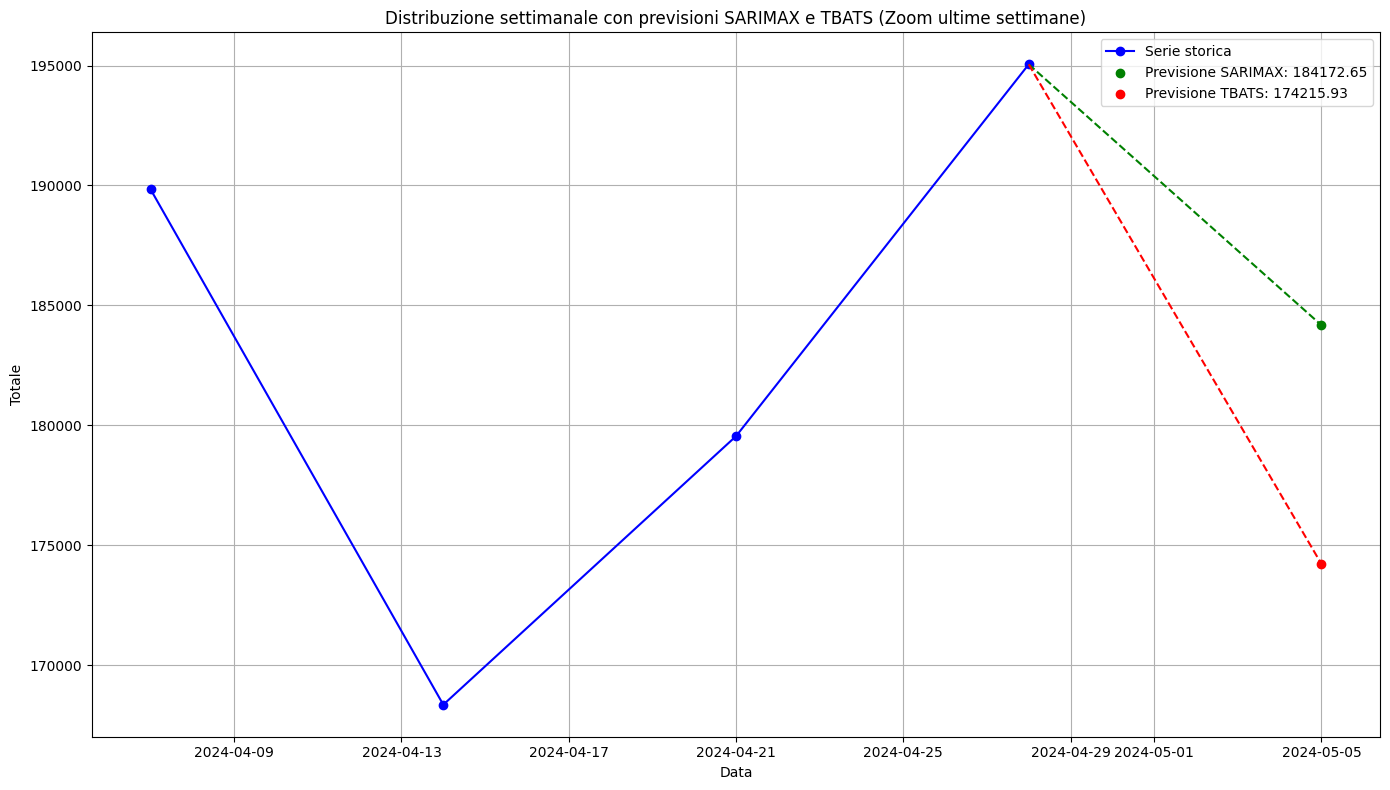

In [ ]:


file_path = '/content/drive/MyDrive/Progetto/output_df/FINALI SETTIMANALI/rist1_final.csv'
weekly_data_cleaned = pd.read_csv(file_path)

weekly_data_cleaned['data'] = pd.to_datetime(weekly_data_cleaned['data'])

sarimax_prediction = round(184172.65, 2)
tbats_prediction = round(174215.93, 2)

weekly_data_cleaned_zoom = weekly_data_cleaned[weekly_data_cleaned['data'] >= '2024-04-01']

plt.figure(figsize=(14, 8))

# Plot serie storica
plt.plot(weekly_data_cleaned_zoom['data'], weekly_data_cleaned_zoom['totale'], label='Serie storica', color='blue', marker='o')

# Aggiungiamo la previsione di SARIMAX
plt.scatter(pd.Timestamp('2024-05-05'), sarimax_prediction, color='green', label=f'Previsione SARIMAX: {sarimax_prediction}', zorder=5)
# Colleghiamo con linea verde alla serie storica
plt.plot([weekly_data_cleaned_zoom['data'].iloc[-1], pd.Timestamp('2024-05-05')],
         [weekly_data_cleaned_zoom['totale'].iloc[-1], sarimax_prediction], color='green', linestyle='--')

# Aggiungiamo la previsione di TBATS
plt.scatter(pd.Timestamp('2024-05-05'), tbats_prediction, color='red', label=f'Previsione TBATS: {tbats_prediction}', zorder=5)
# Colleghiamo con linea rossa alla serie storica
plt.plot([weekly_data_cleaned_zoom['data'].iloc[-1], pd.Timestamp('2024-05-05')],
         [weekly_data_cleaned_zoom['totale'].iloc[-1], tbats_prediction], color='red', linestyle='--')

plt.title('Distribuzione settimanale con previsioni SARIMAX e TBATS (Zoom ultime settimane)')
plt.xlabel('Data')
plt.ylabel('Totale')
plt.grid(True)
plt.legend()

plt.tight_layout()
plt.show()


## FUTURE DEVELOPMENTS

To further improve the accuracy and applicability of the models, several enhancements can be implemented:

1. Incorporate Additional Regressors: Expanding the set of external regressors could provide more context to the models, potentially improving their predictive performance. Including variables such as weather data, local events, or promotions could help capture external influences on restaurant sales, leading to more refined forecasts.

2. Uniform Cross-Validation Method: A key improvement would be to compare all models using the same cross-validation method. By applying the same validation framework (e.g., expanding rolling window or fixed rolling window) across all models, it would be easier to directly compare their performance and draw more consistent conclusions about their strengths and weaknesses.

3. Switch to Daily Data for All Models: Given that daily forecasting is particularly important for this business to manage staff, inventory, and other operational needs, moving to a daily forecasting approach for all models would provide more actionable insights. This shift would allow for finer adjustments in planning and resource allocation, helping optimize operations based on more detailed, day-to-day projections.

By incorporating these enhancements, the models will become more robust and better aligned with the practical needs of the business, leading to improved decision-making and resource management.